# Advanced Solar Radiation Forecasting Models

This notebook implements state-of-the-art deep learning architectures for Global Horizontal Irradiance (GHI) forecasting using time series weather data. Building on the basic models in `3a_ai_modelling_basic.py`, this notebook explores more sophisticated architectures:

1. **TCN (Temporal Convolutional Network)** - Specialized convolutional architecture with dilated convolutions for sequence modeling
2. **Transformer** - Attention-based architecture, adapted for time series forecasting
3. **Informer** - Advanced Transformer variant optimized for long sequence time-series forecasting

## Prerequisites

**IMPORTANT**: Before running this notebook, you must first run the `2_data_preprocessing.py` script to prepare the normalized data. This script generates the train, validation, and test datasets needed for model training and evaluation.

## Workflow Overview

1. **Data Loading** - Load preprocessed time series datasets
2. **Model Training Setup** - Configure training parameters and utilities
3. **Advanced Model Training** - Train cutting-edge deep learning architectures
4. **Performance Evaluation** - Compare state-of-the-art models using various metrics
5. **Visualization** - Plot time series predictions and model comparisons

# 1. Data Loading

In this section, we load and prepare the preprocessed time series data for training our advanced models. The data includes various weather features like temperature, wind speed, solar angles, etc., used to predict the Global Horizontal Irradiance (GHI).

### 1.1 Import modules and define hyperparameters

Here, we define hyperparameters for model training, including the lookback window, batch size, and selected features.

In [1]:
# Load autoreload extension
%load_ext autoreload
# Set autoreload to mode 1
%autoreload 2

# Import required libraries
import os
import numpy as np
from datetime import datetime
import json

import torch
from torch.utils.data import DataLoader
import wandb
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.dates as mdates
# Local modules
from utils.data_persistence import load_scalers
from utils.plot_utils import plot_training_history, plot_evaluation_metrics
from utils.training_utils import train_model, evaluate_model
from utils.wandb_utils import is_wandb_enabled, set_wandb_flag, set_keep_run_open
from utils.model_utils import print_model_info, save_model

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# ========== Model training hyperparameters =========
PATIENCE = 5  # Early stopping patience
LR = 0.0001
# Debug mode to test code. Set to False for actual training
DEBUG_MODE = False

if DEBUG_MODE:
    # Local debug settings (to check if the code is working)
    # Will only run 10 batches/epoch for 10 epochs
    N_EPOCHS = 10
    BATCH_SIZE = 64
    NUM_WORKERS = 4
else:
    # Remote server settings (to train the model, recommend using Otter lab machine)
    N_EPOCHS = 30
    BATCH_SIZE = 2 ** 13   # = 8192 samples
    NUM_WORKERS = 16

# ================= Wandb settings =============
USE_WANDB = True
WANDB_USERNAME = "tin-hoang"  # Your wandb username
WANDB_PROJECT = "EEEM073-Solar-Radiation"  # Your wandb project name

# =========== Time series hyperparameters ===========
# Number of timesteps to look back when creating sequences
LOOKBACK = 24

# Choose features to use in modeling
TIME_FEATURES = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos',
            'month_sin', 'month_cos', 'dow_sin', 'dow_cos']
SELECTED_FEATURES = [
    'air_temperature',
    'wind_speed',
    'relative_humidity',
    'cloud_type',      # Categorical feature
    'solar_zenith_angle',
    'clearsky_ghi',
    'total_precipitable_water',
    'surface_albedo',
    'nighttime_mask',  # New field from preprocess_data
    'cld_opd_dcomp',
    'aod'
]
STATIC_FEATURES = ['latitude', 'longitude', 'elevation']
# Target variable
TARGET_VARIABLE = 'ghi'

Using cuda device


### 1.2 Create PyTorch Datasets and DataLoaders

Here, we set up the PyTorch data pipeline by creating custom datasets and DataLoaders.

In [2]:
# Loading preprocessed data files generated from 2_data_preprocessing.py
# These files contain normalized time series data split into train, validation, and test sets
from utils.data_persistence import load_normalized_data

TRAIN_PREPROCESSED_DATA_PATH = "data/processed/train_normalized_20250430_145157.h5"
VAL_PREPROCESSED_DATA_PATH = "data/processed/val_normalized_20250430_145205.h5"
TEST_PREPROCESSED_DATA_PATH = "data/processed/test_normalized_20250430_145205.h5"

# Load sequences
train_data, metadata = load_normalized_data(TRAIN_PREPROCESSED_DATA_PATH)

SCALER_PATH = "data/processed/scalers_20250430_145206.pkl"
scalers = load_scalers(SCALER_PATH)

# Print metadata
print(f"Train set | Metadata: {metadata}")
# Print created time
print(f"Train set | Created time: {metadata['created_time'] if 'created_time' in metadata else 'No created time'}")
# Print raw files
print(f"Train set | Raw files: {metadata['raw_files'] if 'raw_files' in metadata else 'No raw files'}")

# Print data structure and shape
print(f"Train set | Data structure:")
for key, value in train_data.items():
    print(f"  {key} shape: {value.shape}")

Loaded normalized data from data/processed/train_normalized_20250430_145157.h5
Loaded 16 scalers from data/processed/scalers_20250430_145206.pkl
Train set | Metadata: {'created_time': '2025-04-30 14:51:57'}
Train set | Created time: 2025-04-30 14:51:57
Train set | Raw files: No raw files
Train set | Data structure:
  air_temperature shape: (70128, 105)
  aod shape: (70128, 105)
  cld_opd_dcomp shape: (70128, 105)
  cld_press_acha shape: (70128, 105)
  cld_reff_dcomp shape: (70128, 105)
  clearsky_ghi shape: (70128, 105)
  cloud_type shape: (70128, 105)
  day_cos shape: (70128,)
  day_sin shape: (70128,)
  dow_cos shape: (70128,)
  dow_sin shape: (70128,)
  elevation shape: (105,)
  ghi shape: (70128, 105)
  hour_cos shape: (70128,)
  hour_sin shape: (70128,)
  latitude shape: (105,)
  longitude shape: (105,)
  month_cos shape: (70128,)
  month_sin shape: (70128,)
  nighttime_mask shape: (70128, 105)
  relative_humidity shape: (70128, 105)
  solar_zenith_angle shape: (70128, 105)
  surf

In [3]:
# Creating PyTorch datasets from preprocessed data
# TimeSeriesDataset is a custom dataset class that formats the data for model training
from utils.timeseriesdataset import TimeSeriesDataset

# Create datasets
train_dataset = TimeSeriesDataset(TRAIN_PREPROCESSED_DATA_PATH, lookback=LOOKBACK, target_field=TARGET_VARIABLE,
                                 selected_features=SELECTED_FEATURES, include_target_history=False,
                                 static_features=STATIC_FEATURES)
val_dataset = TimeSeriesDataset(VAL_PREPROCESSED_DATA_PATH, lookback=LOOKBACK, target_field=TARGET_VARIABLE,
                               selected_features=SELECTED_FEATURES, include_target_history=False,
                               static_features=STATIC_FEATURES)
test_dataset = TimeSeriesDataset(TEST_PREPROCESSED_DATA_PATH, lookback=LOOKBACK, target_field=TARGET_VARIABLE,
                                selected_features=SELECTED_FEATURES, include_target_history=False,
                                static_features=STATIC_FEATURES)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Using time feature keys: ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos']
Using static features: ['latitude', 'longitude', 'elevation']
Not using target field history for autoregression
Loaded normalized data from data/processed/train_normalized_20250430_145157.h5
Loaded normalized data file (1/1): data/processed/train_normalized_20250430_145157.h5
Loaded data with 27 features
Using 11 selected features: ['air_temperature', 'aod', 'cld_opd_dcomp', 'clearsky_ghi', 'cloud_type', 'nighttime_mask', 'relative_humidity', 'solar_zenith_angle', 'surface_albedo', 'total_precipitable_water', 'wind_speed']
Temporal features: ['day_cos', 'day_sin', 'dow_cos', 'dow_sin', 'hour_cos', 'hour_sin', 'month_cos', 'month_sin']
Static features: ['latitude', 'longitude', 'elevation']
Time series features: ['air_temperature', 'aod', 'cld_opd_dcomp', 'clearsky_ghi', 'cloud_type', 'nighttime_mask', 'relative_humidity', 'solar_zenith_angle', 'surface_albedo', 'total

In [4]:
# Examining data dimensions to configure model architectures
# Get a batch to determine input dimensions
batch = next(iter(train_loader))

# Check sample batch
sample_batch = next(iter(train_loader))
for key, value in sample_batch.items():
    if isinstance(value, torch.Tensor):
        print(f"{key} shape: {value.shape}")
    elif isinstance(value, list):
        print(f"{key} length: {len(value)}")

# Extract dimensions from a batch (more reliable)
temporal_features = batch['temporal_features']
static_features = batch['static_features']
TEMPORAL_FEATURES_SHAPE = list(temporal_features.shape)
STATIC_FEATURES_SHAPE = list(static_features.shape)

# Check if we have 3D temporal features (batch, seq_len, features)
if len(temporal_features.shape) == 3:
    temporal_dim = temporal_features.shape[2]
else:
    # Handle 2D temporal features (batch, features)
    temporal_dim = temporal_features.shape[1]

static_dim = static_features.shape[1]

print(f"  Input dimensions determined from batch:")
print(f"  - Batch temporal_features shape: {TEMPORAL_FEATURES_SHAPE}")
print(f"  - Batch static_features shape: {STATIC_FEATURES_SHAPE}")
print(f"  - Temporal dimension: {temporal_dim}")
print(f"  - Static dimension: {static_dim}")

static_features shape: torch.Size([8192, 3])
target shape: torch.Size([8192])
temporal_features shape: torch.Size([8192, 24, 19])
air_temperature shape: torch.Size([8192, 24])
aod shape: torch.Size([8192, 24])
cld_opd_dcomp shape: torch.Size([8192, 24])
clearsky_ghi shape: torch.Size([8192, 24])
cloud_type shape: torch.Size([8192, 24])
nighttime_mask shape: torch.Size([8192, 24])
relative_humidity shape: torch.Size([8192, 24])
solar_zenith_angle shape: torch.Size([8192, 24])
surface_albedo shape: torch.Size([8192, 24])
total_precipitable_water shape: torch.Size([8192, 24])
wind_speed shape: torch.Size([8192, 24])
time_index_local length: 8192
current_hour_sin shape: torch.Size([8192])
current_hour_cos shape: torch.Size([8192])
current_day_sin shape: torch.Size([8192])
current_day_cos shape: torch.Size([8192])
current_month_sin shape: torch.Size([8192])
current_month_cos shape: torch.Size([8192])
current_dow_sin shape: torch.Size([8192])
current_dow_cos shape: torch.Size([8192])
  Input

## 2. Model Training Setup

This section configures the training environment, including setting up experiment tracking, defining the training pipeline, and preparing evaluation metrics.

## 2.1 Setting Wandb logging (optional)

Weights & Biases (wandb) is used for experiment tracking. Here we configure whether to use wandb for logging model training progress and results.

In [5]:
# Enable wandb tracking
set_wandb_flag(USE_WANDB)
# Keep the wandb run open after training to continue logging evaluation plots
set_keep_run_open(True)

True

## 2.2 Setup Experiment Pipeline

We define a standardized pipeline for training and evaluating models. This function handles the entire workflow:
1. Model training with early stopping (use train and val set)
2. Evaluation on test data
3. Saving model checkpoints
4. Logging results to wandb (if enabled)

In [6]:
def run_experiment_pipeline(model, train_loader, val_loader, test_loader, model_name, epochs=30, patience=5, lr=0.001):
    """
    Run the experiment pipeline for a given model.

    Args:
        model: The model to train.
        train_loader: The training data loader.
        val_loader: The validation data loader.
        test_loader: The test data loader.
        model_name: The name of the model.
        epochs: The number of epochs to train the model.
        patience: The number of epochs to wait before early stopping.
        lr: The learning rate for the model.
    """
    history, val_metrics, test_metrics = None, None, None

    # Get the current config
    CONFIG = {}
    cur_globals = globals().copy()
    for x in cur_globals:
        # Only get the variables that are uppercase and not digits
        if x.upper() == x and not x.startswith('_') and not x == "CONFIG":
            CONFIG[x] = cur_globals[x]

    try:
        print(f"Training {model_name} model...")
        history = train_model(
            model,
            train_loader,
            val_loader,
            model_name=model_name,
            epochs=epochs,
            patience=patience,
            lr=lr,
            target_scaler=scalers[f'{TARGET_VARIABLE}_scaler'],
            config=CONFIG,
            debug_mode=DEBUG_MODE,
        )
        training_plot = plot_training_history(history, model_name=model_name)

        print(f"\nEvaluating {model_name} model on test set...")
        test_metrics = evaluate_model(
            model,
            test_loader,
            scalers[f'{TARGET_VARIABLE}_scaler'],
            model_name=f"{model_name} - Test",
            debug_mode=DEBUG_MODE,
        )
        test_plot = plot_evaluation_metrics(test_metrics, model_name=f"{model_name} - Test")

        # ========== Save Best Model Checkpoint ===========
        checkpoint_dir = "checkpoints"
        os.makedirs(checkpoint_dir, exist_ok=True)

        # Generate timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Construct filename with timestamp and directory
        model_filename = f"{model_name}_best_{timestamp}.pt"
        model_path = os.path.join(checkpoint_dir, model_filename)

        # Combine time keys and selected features for the complete temporal feature set
        all_temporal_features = TIME_FEATURES + SELECTED_FEATURES

        # Save the model with metadata using the new save_model function
        save_model(
            model=model,
            filepath=model_path,
            metadata={
                "model_name": model_name,
                "timestamp": timestamp,
                "train_metrics": {
                    "final_train_loss": history["train_loss"][-1] if history and "train_loss" in history else None,
                    "final_train_mae": history["train_mae"][-1] if history and "train_mae" in history else None,
                    "final_val_loss": history["val_loss"][-1] if history and "val_loss" in history else None,
                    "final_val_mae": history["val_mae"][-1] if history and "val_mae" in history else None,
                },
                "test_metrics": {
                    "mse": test_metrics["mse"] if test_metrics else None,
                    "rmse": test_metrics["rmse"] if test_metrics else None,
                    "mae": test_metrics["mae"] if test_metrics else None,
                    "r2": test_metrics["r2"] if test_metrics else None,
                }
            },
            temporal_features=all_temporal_features,
            static_features=STATIC_FEATURES,
            time_feature_keys=TIME_FEATURES,
            config=CONFIG
        )

        print(f"Best model saved to {model_path}")

        # Log saved model path to wandb if enabled
        if is_wandb_enabled():
            wandb.save(model_path)
            print(f"Saved model checkpoint logged to wandb: {model_path}")
            wandb.log({"plots/history_plot": wandb.Image(training_plot)})
            wandb.log({"plots/predictions_plot": wandb.Image(test_plot)})

    finally:
        # Finish wandb run if it's still open
        if is_wandb_enabled():
            wandb.finish()

        # Clear GPU memory
        torch.cuda.empty_cache()

    return history, val_metrics, test_metrics

# 3. Advanced Model Experiments

This section implements and trains state-of-the-art neural network architectures for GHI forecasting.
These advanced models can capture more complex temporal patterns compared to basic architectures.

### 3.1 Temporal Convolutional Networks (TCN) Model

TCNs are specialized convolutional architectures for sequence modeling that combine the best of CNNs and RNNs. The key features include:

- **Causal Convolutions**: Each output only depends on current and past inputs.
- **Dilated Convolutions**: Captures larger effective history with fewer parameters.
- **Residual Connections**: Helps with training deep networks and information flow.

TCNs can capture long-range patterns in time series data efficiently, making them suitable for solar radiation forecasting where both short-term weather fluctuations and longer-term patterns matter.

In [7]:
from models.tcn import TCNModel

# Create TCN model
tcn_model = TCNModel(
    input_dim=temporal_dim,
    static_dim=static_dim,
    num_channels=[64, 128, 128, 64],  # Number of channels in each layer
    kernel_size=3,                    # Size of the convolutional kernel
    dropout=0.2,                      # Dropout rate
).to(device)

# Print the model
print_model_info(tcn_model, temporal_features.shape, static_features.shape)

/user/HS402/th01167/.venv/master/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Model: TCNModel
Total parameters: 267,873
Trainable parameters: 267,873
Non-trainable parameters: 0

Model structure:
TCNModel(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(19, 64, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.2, inplace=False)
        (net): Sequential(
          (0): Conv1d(19, 64, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
          (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
          (5): Chomp1d()
          (6): Re

Training TCN model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Creating new wandb run for TCN


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tin-hoang to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training config: {'PATIENCE': 5, 'LR': 0.0001, 'DEBUG_MODE': False, 'N_EPOCHS': 30, 'BATCH_SIZE': 8192, 'NUM_WORKERS': 16, 'USE_WANDB': True, 'WANDB_USERNAME': 'tin-hoang', 'WANDB_PROJECT': 'EEEM073-Solar-Radiation', 'LOOKBACK': 24, 'TIME_FEATURES': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos'], 'SELECTED_FEATURES': ['air_temperature', 'wind_speed', 'relative_humidity', 'cloud_type', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'nighttime_mask', 'cld_opd_dcomp', 'aod'], 'STATIC_FEATURES': ['latitude', 'longitude', 'elevation'], 'TARGET_VARIABLE': 'ghi', 'TRAIN_PREPROCESSED_DATA_PATH': 'data/processed/train_normalized_20250430_145157.h5', 'VAL_PREPROCESSED_DATA_PATH': 'data/processed/val_normalized_20250430_145205.h5', 'TEST_PREPROCESSED_DATA_PATH': 'data/processed/test_normalized_20250430_145205.h5', 'SCALER_PATH': 'data/processed/scalers_20250430_145206.pkl', 'TEMPORAL_FEATURES_SHAPE': [8192, 24, 1


Validation TCN (Epoch 1) Evaluation Metrics:
  Overall:  MSE: 4442.85, RMSE: 66.65, MAE: 39.20, R²: 0.9515, WAPE: 17.25%
  Daytime:  MSE: 8584.51, RMSE: 92.65, MAE: 64.74, R²: 0.8925, WAPE: 14.21%
  Nighttime: MSE: 331.45, RMSE: 18.21, MAE: 13.84, R²: -123.0127, WAPE: 4268.87%
  Inference Speed: 4744170.11 samples/sec, 0.0002 ms/sample
  Total time: 0.1933 sec for 917280 samples
Epoch 1/30 | Train Loss: 40510.9727, Train MAE: 137.1230 | Val Loss: 4442.8550, Val MAE: 39.1985 | LR: 0.000100



Validation TCN (Epoch 2) Evaluation Metrics:
  Overall:  MSE: 3542.53, RMSE: 59.52, MAE: 32.57, R²: 0.9613, WAPE: 14.34%
  Daytime:  MSE: 6940.62, RMSE: 83.31, MAE: 56.47, R²: 0.9131, WAPE: 12.39%
  Nighttime: MSE: 169.25, RMSE: 13.01, MAE: 8.85, R²: -62.3271, WAPE: 2729.60%
  Inference Speed: 4851414.47 samples/sec, 0.0002 ms/sample
  Total time: 0.1891 sec for 917280 samples
Epoch 2/30 | Train Loss: 8633.3145, Train MAE: 65.4456 | Val Loss: 3542.5286, Val MAE: 32.5711 | LR: 0.000100



Validation TCN (Epoch 3) Evaluation Metrics:
  Overall:  MSE: 3254.06, RMSE: 57.04, MAE: 30.03, R²: 0.9645, WAPE: 13.22%
  Daytime:  MSE: 6439.41, RMSE: 80.25, MAE: 53.31, R²: 0.9194, WAPE: 11.70%
  Nighttime: MSE: 91.97, RMSE: 9.59, MAE: 6.92, R²: -33.4126, WAPE: 2133.05%
  Inference Speed: 5458977.93 samples/sec, 0.0002 ms/sample
  Total time: 0.1680 sec for 917280 samples
Epoch 3/30 | Train Loss: 5570.1670, Train MAE: 48.5198 | Val Loss: 3254.0596, Val MAE: 30.0269 | LR: 0.000100



Validation TCN (Epoch 4) Evaluation Metrics:
  Overall:  MSE: 3171.20, RMSE: 56.31, MAE: 29.56, R²: 0.9654, WAPE: 13.01%
  Daytime:  MSE: 6321.86, RMSE: 79.51, MAE: 53.51, R²: 0.9208, WAPE: 11.74%
  Nighttime: MSE: 43.56, RMSE: 6.60, MAE: 5.79, R²: -15.2965, WAPE: 1786.75%
  Inference Speed: 4675385.28 samples/sec, 0.0002 ms/sample
  Total time: 0.1962 sec for 917280 samples
Epoch 4/30 | Train Loss: 4682.6880, Train MAE: 41.3350 | Val Loss: 3171.2029, Val MAE: 29.5637 | LR: 0.000100



Validation TCN (Epoch 5) Evaluation Metrics:
  Overall:  MSE: 3102.05, RMSE: 55.70, MAE: 27.28, R²: 0.9661, WAPE: 12.01%
  Daytime:  MSE: 6210.53, RMSE: 78.81, MAE: 51.56, R²: 0.9222, WAPE: 11.31%
  Nighttime: MSE: 16.27, RMSE: 4.03, MAE: 3.17, R²: -5.0893, WAPE: 978.81%
  Inference Speed: 5113696.83 samples/sec, 0.0002 ms/sample
  Total time: 0.1794 sec for 917280 samples
Epoch 5/30 | Train Loss: 4325.8530, Train MAE: 38.1106 | Val Loss: 3102.0520, Val MAE: 27.2761 | LR: 0.000100



Validation TCN (Epoch 6) Evaluation Metrics:
  Overall:  MSE: 3042.74, RMSE: 55.16, MAE: 26.45, R²: 0.9668, WAPE: 11.64%
  Daytime:  MSE: 6096.24, RMSE: 78.08, MAE: 50.68, R²: 0.9237, WAPE: 11.12%
  Nighttime: MSE: 11.54, RMSE: 3.40, MAE: 2.40, R²: -3.3179, WAPE: 739.53%
  Inference Speed: 5002153.28 samples/sec, 0.0002 ms/sample
  Total time: 0.1834 sec for 917280 samples
Epoch 6/30 | Train Loss: 4142.3994, Train MAE: 36.7734 | Val Loss: 3042.7375, Val MAE: 26.4503 | LR: 0.000100



Validation TCN (Epoch 7) Evaluation Metrics:
  Overall:  MSE: 3017.57, RMSE: 54.93, MAE: 26.08, R²: 0.9671, WAPE: 11.48%
  Daytime:  MSE: 6052.12, RMSE: 77.80, MAE: 50.92, R²: 0.9242, WAPE: 11.17%
  Nighttime: MSE: 5.19, RMSE: 2.28, MAE: 1.42, R²: -0.9405, WAPE: 438.43%
  Inference Speed: 4670288.74 samples/sec, 0.0002 ms/sample
  Total time: 0.1964 sec for 917280 samples
Epoch 7/30 | Train Loss: 4023.5083, Train MAE: 36.0904 | Val Loss: 3017.5701, Val MAE: 26.0781 | LR: 0.000100



Validation TCN (Epoch 8) Evaluation Metrics:
  Overall:  MSE: 2991.00, RMSE: 54.69, MAE: 25.41, R²: 0.9674, WAPE: 11.19%
  Daytime:  MSE: 5999.60, RMSE: 77.46, MAE: 49.73, R²: 0.9249, WAPE: 10.91%
  Nighttime: MSE: 4.38, RMSE: 2.09, MAE: 1.28, R²: -0.6404, WAPE: 393.75%
  Inference Speed: 4559077.95 samples/sec, 0.0002 ms/sample
  Total time: 0.2012 sec for 917280 samples
Epoch 8/30 | Train Loss: 3933.7996, Train MAE: 35.6615 | Val Loss: 2991.0037, Val MAE: 25.4149 | LR: 0.000100



Validation TCN (Epoch 9) Evaluation Metrics:
  Overall:  MSE: 2991.66, RMSE: 54.70, MAE: 25.37, R²: 0.9674, WAPE: 11.17%
  Daytime:  MSE: 6000.53, RMSE: 77.46, MAE: 49.07, R²: 0.9249, WAPE: 10.77%
  Nighttime: MSE: 4.77, RMSE: 2.18, MAE: 1.85, R²: -0.7850, WAPE: 569.61%
  Inference Speed: 4625960.46 samples/sec, 0.0002 ms/sample
  Total time: 0.1983 sec for 917280 samples
Epoch 9/30 | Train Loss: 3856.0198, Train MAE: 35.3325 | Val Loss: 2991.6628, Val MAE: 25.3710 | LR: 0.000100



Validation TCN (Epoch 10) Evaluation Metrics:
  Overall:  MSE: 2977.39, RMSE: 54.57, MAE: 25.47, R²: 0.9675, WAPE: 11.21%
  Daytime:  MSE: 5972.53, RMSE: 77.28, MAE: 49.50, R²: 0.9252, WAPE: 10.86%
  Nighttime: MSE: 4.13, RMSE: 2.03, MAE: 1.60, R²: -0.5446, WAPE: 494.67%
  Inference Speed: 4141367.56 samples/sec, 0.0002 ms/sample
  Total time: 0.2215 sec for 917280 samples
Epoch 10/30 | Train Loss: 3802.5649, Train MAE: 35.1160 | Val Loss: 2977.3933, Val MAE: 25.4659 | LR: 0.000100



Validation TCN (Epoch 11) Evaluation Metrics:
  Overall:  MSE: 2973.68, RMSE: 54.53, MAE: 25.33, R²: 0.9675, WAPE: 11.15%
  Daytime:  MSE: 5965.48, RMSE: 77.24, MAE: 49.19, R²: 0.9253, WAPE: 10.79%
  Nighttime: MSE: 3.72, RMSE: 1.93, MAE: 1.63, R²: -0.3930, WAPE: 503.90%
  Inference Speed: 4736536.42 samples/sec, 0.0002 ms/sample
  Total time: 0.1937 sec for 917280 samples
Epoch 11/30 | Train Loss: 3754.2861, Train MAE: 34.9321 | Val Loss: 2973.6763, Val MAE: 25.3266 | LR: 0.000100



Validation TCN (Epoch 12) Evaluation Metrics:
  Overall:  MSE: 2963.51, RMSE: 54.44, MAE: 25.36, R²: 0.9677, WAPE: 11.16%
  Daytime:  MSE: 5944.45, RMSE: 77.10, MAE: 49.17, R²: 0.9256, WAPE: 10.79%
  Nighttime: MSE: 4.34, RMSE: 2.08, MAE: 1.72, R²: -0.6251, WAPE: 531.40%
  Inference Speed: 4088994.39 samples/sec, 0.0002 ms/sample
  Total time: 0.2243 sec for 917280 samples
Epoch 12/30 | Train Loss: 3718.6736, Train MAE: 34.7997 | Val Loss: 2963.5083, Val MAE: 25.3573 | LR: 0.000100



Validation TCN (Epoch 13) Evaluation Metrics:
  Overall:  MSE: 2977.05, RMSE: 54.56, MAE: 25.33, R²: 0.9675, WAPE: 11.15%
  Daytime:  MSE: 5968.87, RMSE: 77.26, MAE: 48.61, R²: 0.9253, WAPE: 10.67%
  Nighttime: MSE: 7.08, RMSE: 2.66, MAE: 2.21, R²: -1.6503, WAPE: 682.14%
  Inference Speed: 4251221.46 samples/sec, 0.0002 ms/sample
  Total time: 0.2158 sec for 917280 samples
Epoch 13/30 | Train Loss: 3690.5381, Train MAE: 34.7118 | Val Loss: 2977.0496, Val MAE: 25.3271 | LR: 0.000100



Validation TCN (Epoch 14) Evaluation Metrics:
  Overall:  MSE: 2987.13, RMSE: 54.65, MAE: 26.32, R²: 0.9674, WAPE: 11.58%
  Daytime:  MSE: 5991.48, RMSE: 77.40, MAE: 50.80, R²: 0.9250, WAPE: 11.15%
  Nighttime: MSE: 4.72, RMSE: 2.17, MAE: 2.01, R²: -0.7653, WAPE: 621.28%
  Inference Speed: 4494007.38 samples/sec, 0.0002 ms/sample
  Total time: 0.2041 sec for 917280 samples
Epoch 14/30 | Train Loss: 3663.6858, Train MAE: 34.6219 | Val Loss: 2987.1274, Val MAE: 26.3163 | LR: 0.000100



Validation TCN (Epoch 15) Evaluation Metrics:
  Overall:  MSE: 2963.19, RMSE: 54.44, MAE: 25.00, R²: 0.9677, WAPE: 11.00%
  Daytime:  MSE: 5945.37, RMSE: 77.11, MAE: 48.75, R²: 0.9256, WAPE: 10.70%
  Nighttime: MSE: 2.79, RMSE: 1.67, MAE: 1.42, R²: -0.0452, WAPE: 436.94%
  Inference Speed: 5275995.89 samples/sec, 0.0002 ms/sample
  Total time: 0.1739 sec for 917280 samples
Epoch 15/30 | Train Loss: 3639.5464, Train MAE: 34.5355 | Val Loss: 2963.1936, Val MAE: 24.9986 | LR: 0.000100



Validation TCN (Epoch 16) Evaluation Metrics:
  Overall:  MSE: 2962.91, RMSE: 54.43, MAE: 25.33, R²: 0.9677, WAPE: 11.15%
  Daytime:  MSE: 5942.41, RMSE: 77.09, MAE: 48.72, R²: 0.9256, WAPE: 10.69%
  Nighttime: MSE: 5.16, RMSE: 2.27, MAE: 2.11, R²: -0.9321, WAPE: 650.63%
  Inference Speed: 4153071.20 samples/sec, 0.0002 ms/sample
  Total time: 0.2209 sec for 917280 samples
Epoch 16/30 | Train Loss: 3620.5798, Train MAE: 34.4930 | Val Loss: 2962.9070, Val MAE: 25.3284 | LR: 0.000100



Validation TCN (Epoch 17) Evaluation Metrics:
  Overall:  MSE: 2962.30, RMSE: 54.43, MAE: 25.58, R²: 0.9677, WAPE: 11.26%
  Daytime:  MSE: 5943.56, RMSE: 77.09, MAE: 49.82, R²: 0.9256, WAPE: 10.93%
  Nighttime: MSE: 2.82, RMSE: 1.68, MAE: 1.51, R²: -0.0547, WAPE: 466.53%
  Inference Speed: 4873105.84 samples/sec, 0.0002 ms/sample
  Total time: 0.1882 sec for 917280 samples
Epoch 17/30 | Train Loss: 3601.3071, Train MAE: 34.4411 | Val Loss: 2962.3020, Val MAE: 25.5794 | LR: 0.000100



Validation TCN (Epoch 18) Evaluation Metrics:
  Overall:  MSE: 2978.74, RMSE: 54.58, MAE: 25.85, R²: 0.9675, WAPE: 11.38%
  Daytime:  MSE: 5975.95, RMSE: 77.30, MAE: 50.23, R²: 0.9252, WAPE: 11.02%
  Nighttime: MSE: 3.43, RMSE: 1.85, MAE: 1.65, R²: -0.2832, WAPE: 507.38%
  Inference Speed: 4595426.94 samples/sec, 0.0002 ms/sample
  Total time: 0.1996 sec for 917280 samples
Epoch 18/30 | Train Loss: 3581.8384, Train MAE: 34.3993 | Val Loss: 2978.7446, Val MAE: 25.8501 | LR: 0.000100



Validation TCN (Epoch 19) Evaluation Metrics:
  Overall:  MSE: 2956.19, RMSE: 54.37, MAE: 24.77, R²: 0.9677, WAPE: 10.90%
  Daytime:  MSE: 5930.17, RMSE: 77.01, MAE: 47.90, R²: 0.9257, WAPE: 10.51%
  Nighttime: MSE: 3.92, RMSE: 1.98, MAE: 1.81, R²: -0.4653, WAPE: 557.56%
  Inference Speed: 4427581.27 samples/sec, 0.0002 ms/sample
  Total time: 0.2072 sec for 917280 samples
Epoch 19/30 | Train Loss: 3565.9668, Train MAE: 34.3307 | Val Loss: 2956.1851, Val MAE: 24.7683 | LR: 0.000100



Validation TCN (Epoch 20) Evaluation Metrics:
  Overall:  MSE: 2955.38, RMSE: 54.36, MAE: 24.81, R²: 0.9677, WAPE: 10.92%
  Daytime:  MSE: 5930.57, RMSE: 77.01, MAE: 48.68, R²: 0.9257, WAPE: 10.68%
  Nighttime: MSE: 1.92, RMSE: 1.38, MAE: 1.11, R²: 0.2832, WAPE: 342.59%
  Inference Speed: 4527382.07 samples/sec, 0.0002 ms/sample
  Total time: 0.2026 sec for 917280 samples
Epoch 20/30 | Train Loss: 3547.4524, Train MAE: 34.2789 | Val Loss: 2955.3770, Val MAE: 24.8084 | LR: 0.000100



Validation TCN (Epoch 21) Evaluation Metrics:
  Overall:  MSE: 2962.57, RMSE: 54.43, MAE: 25.36, R²: 0.9677, WAPE: 11.16%
  Daytime:  MSE: 5944.04, RMSE: 77.10, MAE: 49.38, R²: 0.9256, WAPE: 10.84%
  Nighttime: MSE: 2.88, RMSE: 1.70, MAE: 1.51, R²: -0.0794, WAPE: 466.10%
  Inference Speed: 4661664.76 samples/sec, 0.0002 ms/sample
  Total time: 0.1968 sec for 917280 samples
Epoch 21/30 | Train Loss: 3537.1404, Train MAE: 34.2571 | Val Loss: 2962.5725, Val MAE: 25.3590 | LR: 0.000100



Validation TCN (Epoch 22) Evaluation Metrics:
  Overall:  MSE: 2943.60, RMSE: 54.25, MAE: 24.85, R²: 0.9679, WAPE: 10.94%
  Daytime:  MSE: 5907.57, RMSE: 76.86, MAE: 49.22, R²: 0.9260, WAPE: 10.80%
  Nighttime: MSE: 1.28, RMSE: 1.13, MAE: 0.66, R²: 0.5198, WAPE: 203.32%
  Inference Speed: 4522709.26 samples/sec, 0.0002 ms/sample
  Total time: 0.2028 sec for 917280 samples
Epoch 22/30 | Train Loss: 3518.5525, Train MAE: 34.1966 | Val Loss: 2943.6030, Val MAE: 24.8523 | LR: 0.000100



Validation TCN (Epoch 23) Evaluation Metrics:
  Overall:  MSE: 2962.58, RMSE: 54.43, MAE: 24.80, R²: 0.9677, WAPE: 10.91%
  Daytime:  MSE: 5946.04, RMSE: 77.11, MAE: 49.14, R²: 0.9256, WAPE: 10.78%
  Nighttime: MSE: 0.91, RMSE: 0.96, MAE: 0.63, R²: 0.6580, WAPE: 192.95%
  Inference Speed: 4725123.12 samples/sec, 0.0002 ms/sample
  Total time: 0.1941 sec for 917280 samples
Epoch 23/30 | Train Loss: 3504.2014, Train MAE: 34.1546 | Val Loss: 2962.5837, Val MAE: 24.7956 | LR: 0.000100



Validation TCN (Epoch 24) Evaluation Metrics:
  Overall:  MSE: 2950.49, RMSE: 54.32, MAE: 25.41, R²: 0.9678, WAPE: 11.19%
  Daytime:  MSE: 5920.48, RMSE: 76.94, MAE: 49.76, R²: 0.9259, WAPE: 10.92%
  Nighttime: MSE: 2.19, RMSE: 1.48, MAE: 1.24, R²: 0.1822, WAPE: 381.73%
  Inference Speed: 4869707.25 samples/sec, 0.0002 ms/sample
  Total time: 0.1884 sec for 917280 samples
Epoch 24/30 | Train Loss: 3494.1729, Train MAE: 34.1328 | Val Loss: 2950.4905, Val MAE: 25.4124 | LR: 0.000100



Validation TCN (Epoch 25) Evaluation Metrics:
  Overall:  MSE: 2972.94, RMSE: 54.52, MAE: 25.56, R²: 0.9676, WAPE: 11.25%
  Daytime:  MSE: 5962.70, RMSE: 77.22, MAE: 49.16, R²: 0.9253, WAPE: 10.79%
  Nighttime: MSE: 5.01, RMSE: 2.24, MAE: 2.12, R²: -0.8734, WAPE: 653.98%
  Inference Speed: 4716763.98 samples/sec, 0.0002 ms/sample
  Total time: 0.1945 sec for 917280 samples
Epoch 25/30 | Train Loss: 3482.0527, Train MAE: 34.1069 | Val Loss: 2972.9370, Val MAE: 25.5550 | LR: 0.000100



Validation TCN (Epoch 26) Evaluation Metrics:
  Overall:  MSE: 2977.57, RMSE: 54.57, MAE: 25.11, R²: 0.9675, WAPE: 11.05%
  Daytime:  MSE: 5975.39, RMSE: 77.30, MAE: 49.31, R²: 0.9252, WAPE: 10.82%
  Nighttime: MSE: 1.65, RMSE: 1.29, MAE: 1.08, R²: 0.3810, WAPE: 334.17%
  Inference Speed: 4793394.73 samples/sec, 0.0002 ms/sample
  Total time: 0.1914 sec for 917280 samples
Epoch 26/30 | Train Loss: 3470.3267, Train MAE: 34.0549 | Val Loss: 2977.5720, Val MAE: 25.1074 | LR: 0.000100



Validation TCN (Epoch 27) Evaluation Metrics:
  Overall:  MSE: 2996.05, RMSE: 54.74, MAE: 25.83, R²: 0.9673, WAPE: 11.37%
  Daytime:  MSE: 6010.12, RMSE: 77.52, MAE: 49.97, R²: 0.9247, WAPE: 10.97%
  Nighttime: MSE: 3.99, RMSE: 2.00, MAE: 1.86, R²: -0.4911, WAPE: 573.52%
  Inference Speed: 5023865.00 samples/sec, 0.0002 ms/sample
  Total time: 0.1826 sec for 917280 samples
Epoch 27/30 | Train Loss: 3455.9431, Train MAE: 34.0081 | Val Loss: 2996.0476, Val MAE: 25.8277 | LR: 0.000100
Early stopping at epoch 27
Loading best model from training session. The model object now can be used to make predictions.
Keeping wandb run open as requested (keep_run_open=True)


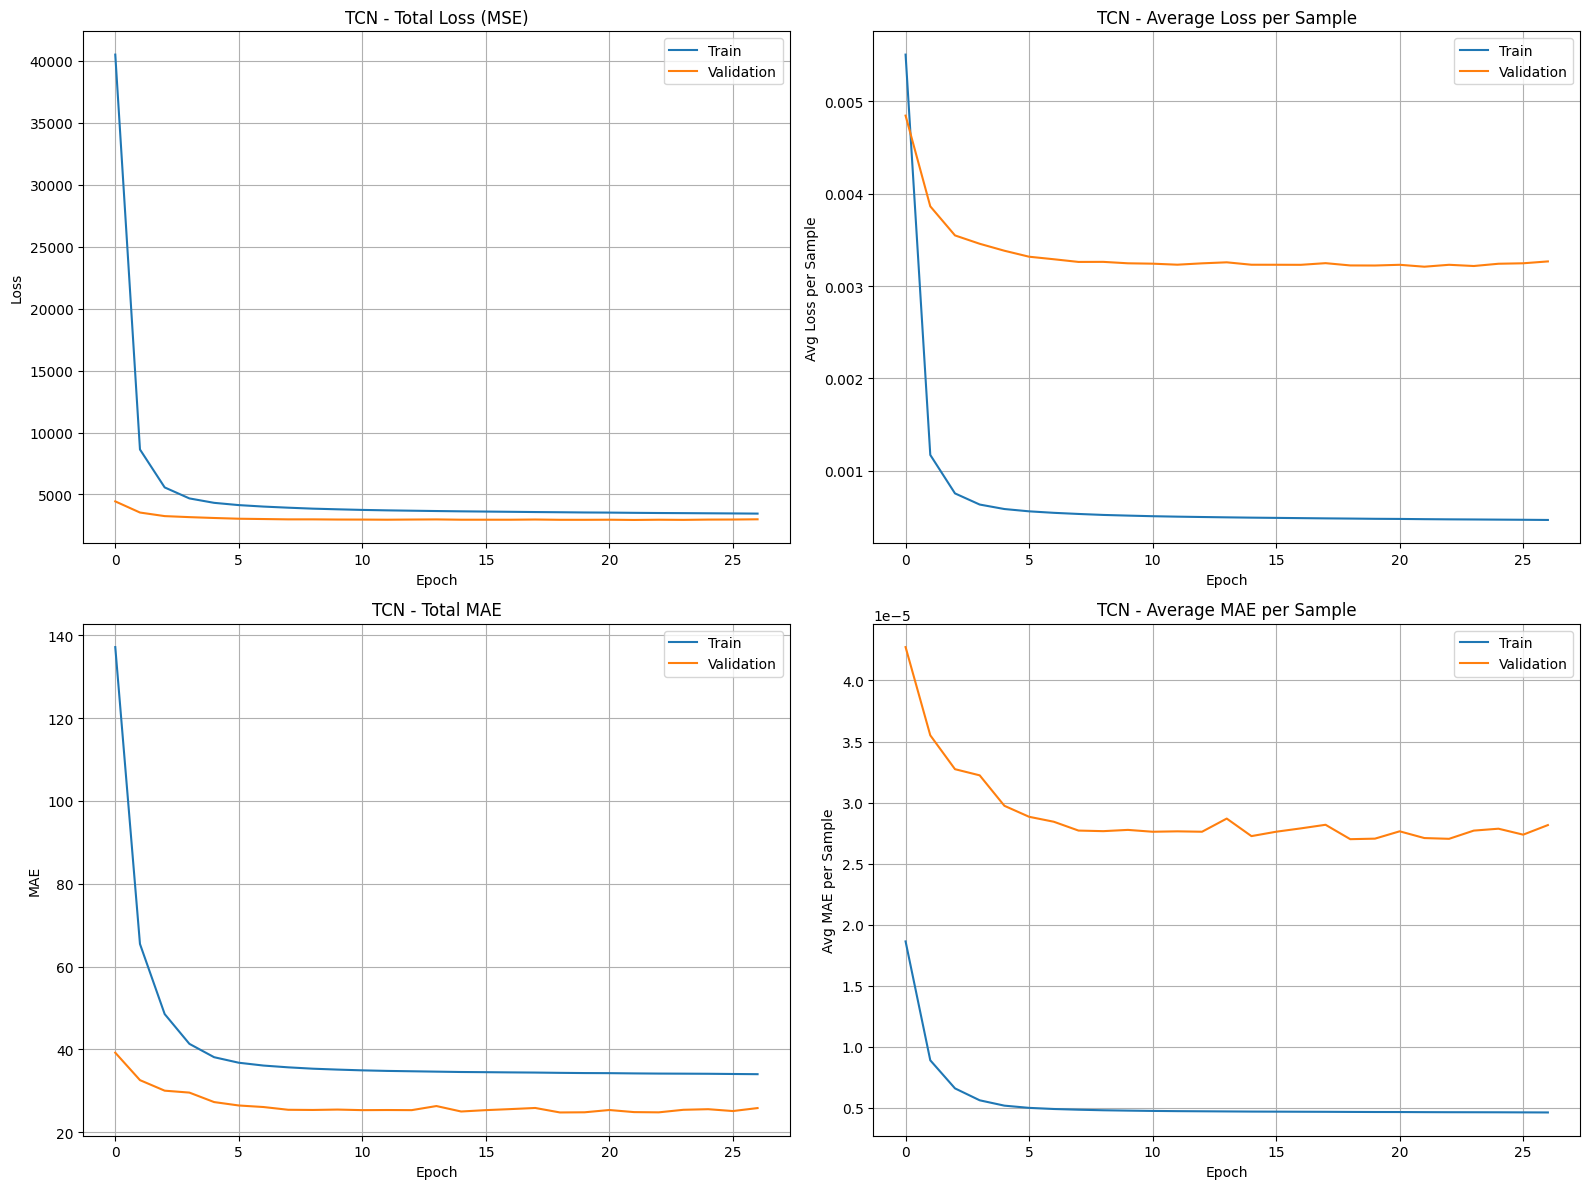


Evaluating TCN model on test set...



TCN - Test Evaluation Metrics:
  Overall:  MSE: 2876.86, RMSE: 53.64, MAE: 25.68, R²: 0.9689, WAPE: 11.33%
  Daytime:  MSE: 5771.09, RMSE: 75.97, MAE: 49.67, R²: 0.9299, WAPE: 10.93%
  Nighttime: MSE: 3.99, RMSE: 2.00, MAE: 1.86, R²: -0.5299, WAPE: 589.22%
  Inference Speed: 4178549.26 samples/sec, 0.0002 ms/sample
  Total time: 0.2201 sec for 919800 samples
Model saved to checkpoints/TCN_best_20250502_161854.pt with metadata.
Best model saved to checkpoints/TCN_best_20250502_161854.pt
Saved model checkpoint logged to wandb: checkpoints/TCN_best_20250502_161854.pt


test/inference_speed_samples_per_sec,▁
test/inference_time_ms_per_sample,▁
test/mae,▁
test/mse,▁
test/r2,▁
test/rmse,▁
test/wape,▁
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


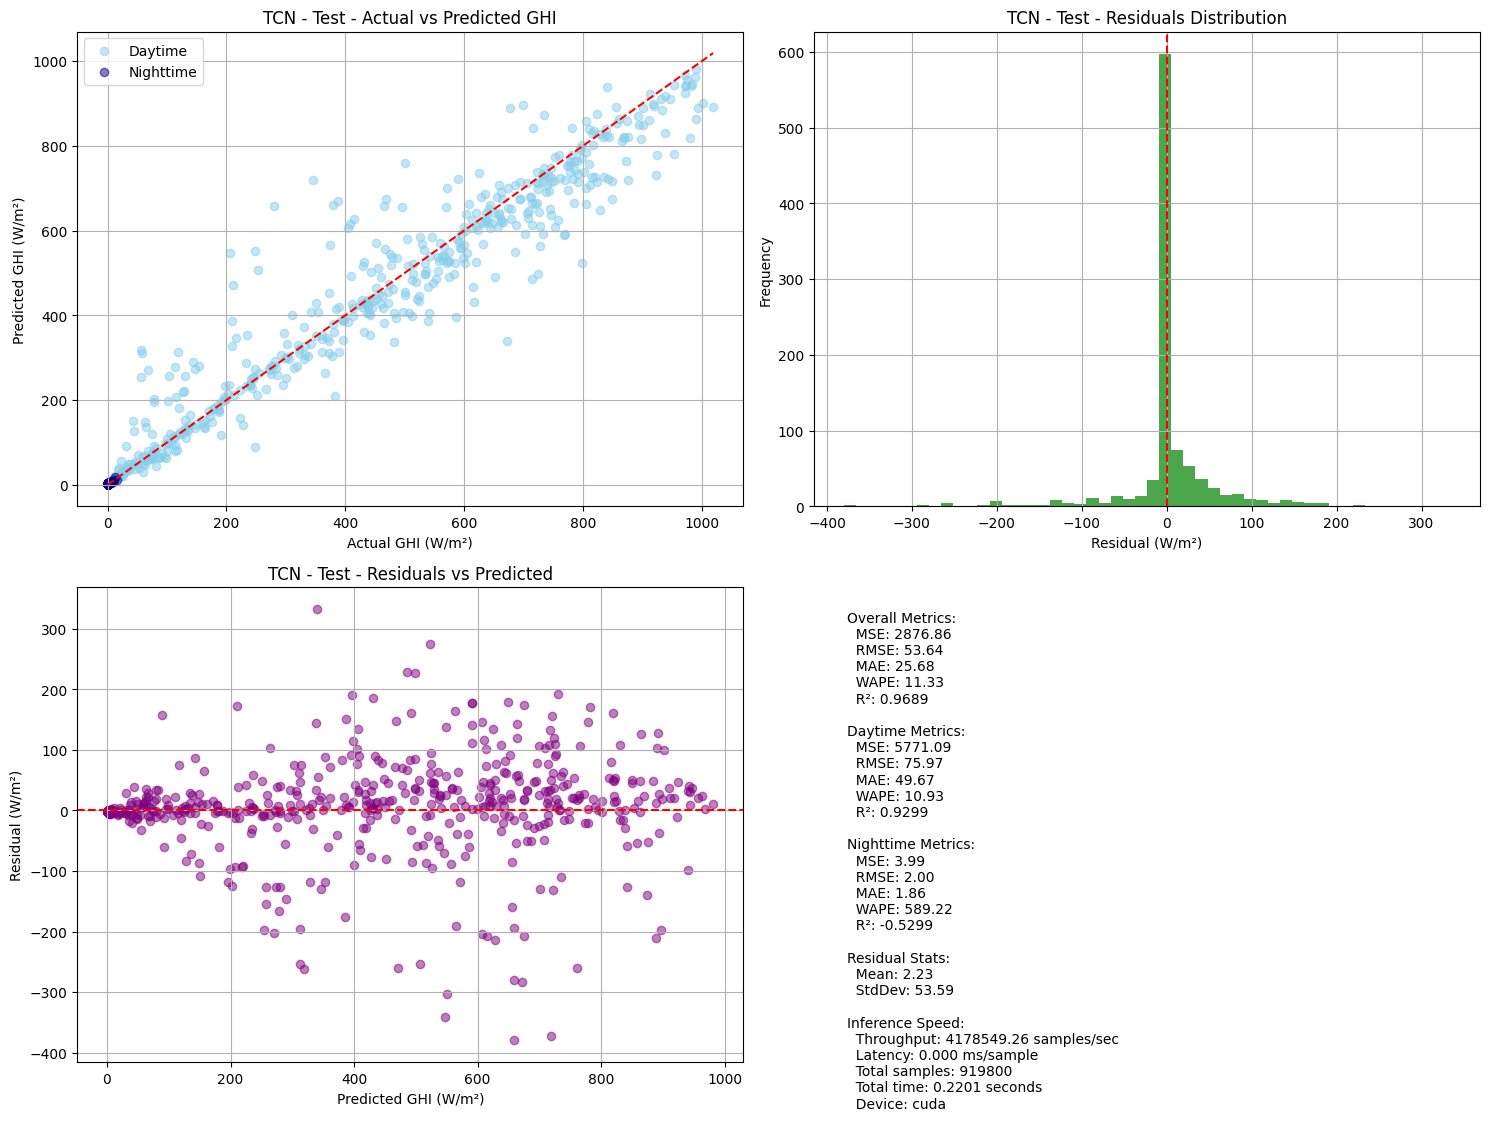

In [8]:
model_name = "TCN"

# Train the TCN model
tcn_history, tcn_val_metrics, tcn_test_metrics = run_experiment_pipeline(
    tcn_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)

### 3.2 Transformer Model

Transformers revolutionized natural language processing and have been adapted for time series forecasting with impressive results. Their key advantages include:

- **Self-Attention Mechanism**: Allows the model to weight the importance of different input time steps dynamically.
- **Parallelization**: Can process the entire sequence in parallel, unlike RNNs.
- **Long-range Dependencies**: Captures dependencies at arbitrary distances in the sequence.

For solar forecasting, Transformers can identify complex temporal patterns across different time scales and account for both short-term and long-term relationships in the weather and solar data.

In [9]:
from models.transformer import TransformerModel

# Create Transformer model
transformer_model = TransformerModel(
    input_dim=temporal_dim,           # Dimension of input features
    static_dim=static_dim,            # Dimension of static features
    d_model=128,                      # Transformer model dimension
    nhead=4,                          # Number of attention heads
    num_layers=2,                     # Number of transformer layers
    dim_feedforward=256,              # Dimension of feedforward network
    dropout=0.2,                      # Dropout rate
).to(device)

# Print the model
print_model_info(transformer_model, temporal_features.shape, static_features.shape)

Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Model: TransformerModel
Total parameters: 280,577
Trainable parameters: 280,577
Non-trainable parameters: 0

Model structure:
TransformerModel(
  (input_projection): Linear(in_features=19, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): D

Training Transformer model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Creating new wandb run for Transformer


Training config: {'PATIENCE': 5, 'LR': 0.0001, 'DEBUG_MODE': False, 'N_EPOCHS': 30, 'BATCH_SIZE': 8192, 'NUM_WORKERS': 16, 'USE_WANDB': True, 'WANDB_USERNAME': 'tin-hoang', 'WANDB_PROJECT': 'EEEM073-Solar-Radiation', 'LOOKBACK': 24, 'TIME_FEATURES': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos'], 'SELECTED_FEATURES': ['air_temperature', 'wind_speed', 'relative_humidity', 'cloud_type', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'nighttime_mask', 'cld_opd_dcomp', 'aod'], 'STATIC_FEATURES': ['latitude', 'longitude', 'elevation'], 'TARGET_VARIABLE': 'ghi', 'TRAIN_PREPROCESSED_DATA_PATH': 'data/processed/train_normalized_20250430_145157.h5', 'VAL_PREPROCESSED_DATA_PATH': 'data/processed/val_normalized_20250430_145205.h5', 'TEST_PREPROCESSED_DATA_PATH': 'data/processed/test_normalized_20250430_145205.h5', 'SCALER_PATH': 'data/processed/scalers_20250430_145206.pkl', 'TEMPORAL_FEATURES_SHAPE': [8192, 24, 1


Validation Transformer (Epoch 1) Evaluation Metrics:
  Overall:  MSE: 4400.78, RMSE: 66.34, MAE: 44.06, R²: 0.9520, WAPE: 19.39%
  Daytime:  MSE: 7733.10, RMSE: 87.94, MAE: 61.07, R²: 0.9032, WAPE: 13.40%
  Nighttime: MSE: 1092.80, RMSE: 33.06, MAE: 27.17, R²: -407.8759, WAPE: 8381.17%
  Inference Speed: 7091303.34 samples/sec, 0.0001 ms/sample
  Total time: 0.1294 sec for 917280 samples
Epoch 1/30 | Train Loss: 33162.0000, Train MAE: 129.3600 | Val Loss: 4400.7788, Val MAE: 44.0594 | LR: 0.000100



Validation Transformer (Epoch 2) Evaluation Metrics:
  Overall:  MSE: 3395.64, RMSE: 58.27, MAE: 33.31, R²: 0.9629, WAPE: 14.66%
  Daytime:  MSE: 6594.15, RMSE: 81.20, MAE: 53.97, R²: 0.9174, WAPE: 11.84%
  Nighttime: MSE: 220.49, RMSE: 14.85, MAE: 12.79, R²: -81.4982, WAPE: 3945.95%
  Inference Speed: 6957889.66 samples/sec, 0.0001 ms/sample
  Total time: 0.1318 sec for 917280 samples
Epoch 2/30 | Train Loss: 9059.3174, Train MAE: 63.2298 | Val Loss: 3395.6411, Val MAE: 33.3068 | LR: 0.000100



Validation Transformer (Epoch 3) Evaluation Metrics:
  Overall:  MSE: 3252.58, RMSE: 57.03, MAE: 31.77, R²: 0.9645, WAPE: 13.98%
  Daytime:  MSE: 6404.49, RMSE: 80.03, MAE: 53.61, R²: 0.9198, WAPE: 11.76%
  Nighttime: MSE: 123.68, RMSE: 11.12, MAE: 10.09, R²: -45.2757, WAPE: 3111.81%
  Inference Speed: 6635778.14 samples/sec, 0.0002 ms/sample
  Total time: 0.1382 sec for 917280 samples
Epoch 3/30 | Train Loss: 6328.7510, Train MAE: 47.3951 | Val Loss: 3252.5759, Val MAE: 31.7689 | LR: 0.000100



Validation Transformer (Epoch 4) Evaluation Metrics:
  Overall:  MSE: 3125.77, RMSE: 55.91, MAE: 28.51, R²: 0.9659, WAPE: 12.55%
  Daytime:  MSE: 6231.09, RMSE: 78.94, MAE: 51.85, R²: 0.9220, WAPE: 11.38%
  Nighttime: MSE: 43.12, RMSE: 6.57, MAE: 5.35, R²: -15.1353, WAPE: 1649.31%
  Inference Speed: 7268313.98 samples/sec, 0.0001 ms/sample
  Total time: 0.1262 sec for 917280 samples
Epoch 4/30 | Train Loss: 5557.2646, Train MAE: 43.1871 | Val Loss: 3125.7688, Val MAE: 28.5120 | LR: 0.000100



Validation Transformer (Epoch 5) Evaluation Metrics:
  Overall:  MSE: 3155.13, RMSE: 56.17, MAE: 28.86, R²: 0.9656, WAPE: 12.70%
  Daytime:  MSE: 6309.27, RMSE: 79.43, MAE: 54.08, R²: 0.9210, WAPE: 11.87%
  Nighttime: MSE: 24.03, RMSE: 4.90, MAE: 3.84, R²: -7.9904, WAPE: 1183.03%
  Inference Speed: 7916816.55 samples/sec, 0.0001 ms/sample
  Total time: 0.1159 sec for 917280 samples
Epoch 5/30 | Train Loss: 5188.4321, Train MAE: 41.5699 | Val Loss: 3155.1287, Val MAE: 28.8641 | LR: 0.000100



Validation Transformer (Epoch 6) Evaluation Metrics:
  Overall:  MSE: 3059.88, RMSE: 55.32, MAE: 26.62, R²: 0.9666, WAPE: 11.72%
  Daytime:  MSE: 6129.45, RMSE: 78.29, MAE: 50.74, R²: 0.9233, WAPE: 11.13%
  Nighttime: MSE: 12.73, RMSE: 3.57, MAE: 2.67, R²: -3.7616, WAPE: 822.10%
  Inference Speed: 8313779.63 samples/sec, 0.0001 ms/sample
  Total time: 0.1103 sec for 917280 samples
Epoch 6/30 | Train Loss: 4937.7334, Train MAE: 40.4757 | Val Loss: 3059.8804, Val MAE: 26.6165 | LR: 0.000100



Validation Transformer (Epoch 7) Evaluation Metrics:
  Overall:  MSE: 3027.99, RMSE: 55.03, MAE: 25.50, R²: 0.9670, WAPE: 11.23%
  Daytime:  MSE: 6070.31, RMSE: 77.91, MAE: 49.66, R²: 0.9240, WAPE: 10.90%
  Nighttime: MSE: 7.89, RMSE: 2.81, MAE: 1.52, R²: -1.9529, WAPE: 469.14%
  Inference Speed: 8120800.76 samples/sec, 0.0001 ms/sample
  Total time: 0.1130 sec for 917280 samples
Epoch 7/30 | Train Loss: 4769.3149, Train MAE: 39.8989 | Val Loss: 3027.9937, Val MAE: 25.5047 | LR: 0.000100



Validation Transformer (Epoch 8) Evaluation Metrics:
  Overall:  MSE: 3102.80, RMSE: 55.70, MAE: 24.67, R²: 0.9661, WAPE: 10.86%
  Daytime:  MSE: 6223.86, RMSE: 78.89, MAE: 48.46, R²: 0.9221, WAPE: 10.63%
  Nighttime: MSE: 4.53, RMSE: 2.13, MAE: 1.06, R²: -0.6967, WAPE: 325.40%
  Inference Speed: 7811531.61 samples/sec, 0.0001 ms/sample
  Total time: 0.1174 sec for 917280 samples
Epoch 8/30 | Train Loss: 4656.5376, Train MAE: 39.6562 | Val Loss: 3102.7993, Val MAE: 24.6708 | LR: 0.000100



Validation Transformer (Epoch 9) Evaluation Metrics:
  Overall:  MSE: 3009.64, RMSE: 54.86, MAE: 24.71, R²: 0.9672, WAPE: 10.88%
  Daytime:  MSE: 6037.12, RMSE: 77.70, MAE: 48.43, R²: 0.9244, WAPE: 10.63%
  Nighttime: MSE: 4.28, RMSE: 2.07, MAE: 1.17, R²: -0.6022, WAPE: 359.58%
  Inference Speed: 9018490.49 samples/sec, 0.0001 ms/sample
  Total time: 0.1017 sec for 917280 samples
Epoch 9/30 | Train Loss: 4564.5083, Train MAE: 39.4203 | Val Loss: 3009.6440, Val MAE: 24.7131 | LR: 0.000100



Validation Transformer (Epoch 10) Evaluation Metrics:
  Overall:  MSE: 2977.41, RMSE: 54.57, MAE: 25.59, R²: 0.9675, WAPE: 11.26%
  Daytime:  MSE: 5970.86, RMSE: 77.27, MAE: 49.40, R²: 0.9252, WAPE: 10.84%
  Nighttime: MSE: 5.83, RMSE: 2.41, MAE: 1.96, R²: -1.1813, WAPE: 605.47%
  Inference Speed: 7339765.94 samples/sec, 0.0001 ms/sample
  Total time: 0.1250 sec for 917280 samples
Epoch 10/30 | Train Loss: 4501.5288, Train MAE: 39.3496 | Val Loss: 2977.4148, Val MAE: 25.5932 | LR: 0.000100



Validation Transformer (Epoch 11) Evaluation Metrics:
  Overall:  MSE: 3046.58, RMSE: 55.20, MAE: 27.36, R²: 0.9668, WAPE: 12.04%
  Daytime:  MSE: 6107.98, RMSE: 78.15, MAE: 52.40, R²: 0.9235, WAPE: 11.50%
  Nighttime: MSE: 7.53, RMSE: 2.74, MAE: 2.51, R²: -1.8188, WAPE: 774.51%
  Inference Speed: 7728755.24 samples/sec, 0.0001 ms/sample
  Total time: 0.1187 sec for 917280 samples
Epoch 11/30 | Train Loss: 4453.0654, Train MAE: 39.3013 | Val Loss: 3046.5774, Val MAE: 27.3636 | LR: 0.000100



Validation Transformer (Epoch 12) Evaluation Metrics:
  Overall:  MSE: 3005.82, RMSE: 54.83, MAE: 26.40, R²: 0.9672, WAPE: 11.62%
  Daytime:  MSE: 6026.37, RMSE: 77.63, MAE: 50.52, R²: 0.9245, WAPE: 11.08%
  Nighttime: MSE: 7.33, RMSE: 2.71, MAE: 2.45, R²: -1.7419, WAPE: 756.71%
  Inference Speed: 7222590.50 samples/sec, 0.0001 ms/sample
  Total time: 0.1270 sec for 917280 samples
Epoch 12/30 | Train Loss: 4413.5933, Train MAE: 39.2256 | Val Loss: 3005.8193, Val MAE: 26.3966 | LR: 0.000100



Validation Transformer (Epoch 13) Evaluation Metrics:
  Overall:  MSE: 2997.91, RMSE: 54.75, MAE: 26.47, R²: 0.9673, WAPE: 11.65%
  Daytime:  MSE: 6009.62, RMSE: 77.52, MAE: 50.43, R²: 0.9248, WAPE: 11.07%
  Nighttime: MSE: 8.19, RMSE: 2.86, MAE: 2.67, R²: -2.0650, WAPE: 824.60%
  Inference Speed: 7885580.71 samples/sec, 0.0001 ms/sample
  Total time: 0.1163 sec for 917280 samples
Epoch 13/30 | Train Loss: 4381.7637, Train MAE: 39.1536 | Val Loss: 2997.9065, Val MAE: 26.4651 | LR: 0.000100



Validation Transformer (Epoch 14) Evaluation Metrics:
  Overall:  MSE: 2973.31, RMSE: 54.53, MAE: 25.95, R²: 0.9676, WAPE: 11.42%
  Daytime:  MSE: 5961.45, RMSE: 77.21, MAE: 49.65, R²: 0.9254, WAPE: 10.89%
  Nighttime: MSE: 7.00, RMSE: 2.65, MAE: 2.42, R²: -1.6187, WAPE: 744.84%
  Inference Speed: 7210664.84 samples/sec, 0.0001 ms/sample
  Total time: 0.1272 sec for 917280 samples
Epoch 14/30 | Train Loss: 4353.9551, Train MAE: 39.0975 | Val Loss: 2973.3110, Val MAE: 25.9462 | LR: 0.000100



Validation Transformer (Epoch 15) Evaluation Metrics:
  Overall:  MSE: 2979.28, RMSE: 54.58, MAE: 24.85, R²: 0.9675, WAPE: 10.94%
  Daytime:  MSE: 5973.25, RMSE: 77.29, MAE: 47.35, R²: 0.9252, WAPE: 10.39%
  Nighttime: MSE: 7.18, RMSE: 2.68, MAE: 2.50, R²: -1.6878, WAPE: 771.45%
  Inference Speed: 7145724.89 samples/sec, 0.0001 ms/sample
  Total time: 0.1284 sec for 917280 samples
Epoch 15/30 | Train Loss: 4324.4282, Train MAE: 39.0014 | Val Loss: 2979.2820, Val MAE: 24.8454 | LR: 0.000100



Validation Transformer (Epoch 16) Evaluation Metrics:
  Overall:  MSE: 3009.72, RMSE: 54.86, MAE: 26.08, R²: 0.9672, WAPE: 11.48%
  Daytime:  MSE: 6029.13, RMSE: 77.65, MAE: 49.47, R²: 0.9245, WAPE: 10.86%
  Nighttime: MSE: 12.35, RMSE: 3.51, MAE: 2.86, R²: -3.6213, WAPE: 881.54%
  Inference Speed: 6920717.04 samples/sec, 0.0001 ms/sample
  Total time: 0.1325 sec for 917280 samples
Epoch 16/30 | Train Loss: 4299.9521, Train MAE: 38.9167 | Val Loss: 3009.7153, Val MAE: 26.0799 | LR: 0.000100



Validation Transformer (Epoch 17) Evaluation Metrics:
  Overall:  MSE: 2952.27, RMSE: 54.33, MAE: 25.92, R²: 0.9678, WAPE: 11.41%
  Daytime:  MSE: 5920.04, RMSE: 76.94, MAE: 49.64, R²: 0.9259, WAPE: 10.89%
  Nighttime: MSE: 6.17, RMSE: 2.48, MAE: 2.37, R²: -1.3080, WAPE: 731.54%
  Inference Speed: 8156248.11 samples/sec, 0.0001 ms/sample
  Total time: 0.1125 sec for 917280 samples
Epoch 17/30 | Train Loss: 4282.4141, Train MAE: 38.8634 | Val Loss: 2952.2664, Val MAE: 25.9182 | LR: 0.000100



Validation Transformer (Epoch 18) Evaluation Metrics:
  Overall:  MSE: 2966.07, RMSE: 54.46, MAE: 26.33, R²: 0.9676, WAPE: 11.59%
  Daytime:  MSE: 5948.82, RMSE: 77.13, MAE: 50.70, R²: 0.9255, WAPE: 11.12%
  Nighttime: MSE: 5.11, RMSE: 2.26, MAE: 2.14, R²: -0.9106, WAPE: 660.33%
  Inference Speed: 7178764.54 samples/sec, 0.0001 ms/sample
  Total time: 0.1278 sec for 917280 samples
Epoch 18/30 | Train Loss: 4260.7163, Train MAE: 38.7931 | Val Loss: 2966.0706, Val MAE: 26.3306 | LR: 0.000100



Validation Transformer (Epoch 19) Evaluation Metrics:
  Overall:  MSE: 2956.53, RMSE: 54.37, MAE: 25.63, R²: 0.9677, WAPE: 11.28%
  Daytime:  MSE: 5929.61, RMSE: 77.00, MAE: 49.27, R²: 0.9258, WAPE: 10.81%
  Nighttime: MSE: 5.15, RMSE: 2.27, MAE: 2.17, R²: -0.9276, WAPE: 667.76%
  Inference Speed: 6957273.14 samples/sec, 0.0001 ms/sample
  Total time: 0.1318 sec for 917280 samples
Epoch 19/30 | Train Loss: 4243.6709, Train MAE: 38.7260 | Val Loss: 2956.5251, Val MAE: 25.6289 | LR: 0.000100



Validation Transformer (Epoch 20) Evaluation Metrics:
  Overall:  MSE: 2930.75, RMSE: 54.14, MAE: 25.25, R²: 0.9680, WAPE: 11.11%
  Daytime:  MSE: 5877.54, RMSE: 76.67, MAE: 48.69, R²: 0.9264, WAPE: 10.68%
  Nighttime: MSE: 5.49, RMSE: 2.34, MAE: 1.99, R²: -1.0525, WAPE: 612.24%
  Inference Speed: 7352544.34 samples/sec, 0.0001 ms/sample
  Total time: 0.1248 sec for 917280 samples
Epoch 20/30 | Train Loss: 4224.7324, Train MAE: 38.6564 | Val Loss: 2930.7532, Val MAE: 25.2525 | LR: 0.000100



Validation Transformer (Epoch 21) Evaluation Metrics:
  Overall:  MSE: 2935.48, RMSE: 54.18, MAE: 25.12, R²: 0.9680, WAPE: 11.06%
  Daytime:  MSE: 5886.26, RMSE: 76.72, MAE: 47.99, R²: 0.9263, WAPE: 10.53%
  Nighttime: MSE: 6.25, RMSE: 2.50, MAE: 2.43, R²: -1.3385, WAPE: 748.05%
  Inference Speed: 7439785.53 samples/sec, 0.0001 ms/sample
  Total time: 0.1233 sec for 917280 samples
Epoch 21/30 | Train Loss: 4215.4570, Train MAE: 38.6400 | Val Loss: 2935.4800, Val MAE: 25.1221 | LR: 0.000100



Validation Transformer (Epoch 22) Evaluation Metrics:
  Overall:  MSE: 2960.29, RMSE: 54.41, MAE: 26.55, R²: 0.9677, WAPE: 11.69%
  Daytime:  MSE: 5932.91, RMSE: 77.03, MAE: 50.28, R²: 0.9257, WAPE: 11.03%
  Nighttime: MSE: 9.39, RMSE: 3.06, MAE: 2.99, R²: -2.5119, WAPE: 922.77%
  Inference Speed: 8199618.45 samples/sec, 0.0001 ms/sample
  Total time: 0.1119 sec for 917280 samples
Epoch 22/30 | Train Loss: 4198.3721, Train MAE: 38.5780 | Val Loss: 2960.2917, Val MAE: 26.5501 | LR: 0.000100



Validation Transformer (Epoch 23) Evaluation Metrics:
  Overall:  MSE: 2992.33, RMSE: 54.70, MAE: 24.82, R²: 0.9673, WAPE: 10.92%
  Daytime:  MSE: 6001.00, RMSE: 77.47, MAE: 47.52, R²: 0.9249, WAPE: 10.43%
  Nighttime: MSE: 5.63, RMSE: 2.37, MAE: 2.28, R²: -1.1052, WAPE: 703.02%
  Inference Speed: 8515625.69 samples/sec, 0.0001 ms/sample
  Total time: 0.1077 sec for 917280 samples
Epoch 23/30 | Train Loss: 4185.2417, Train MAE: 38.5238 | Val Loss: 2992.3254, Val MAE: 24.8187 | LR: 0.000100



Validation Transformer (Epoch 24) Evaluation Metrics:
  Overall:  MSE: 2989.73, RMSE: 54.68, MAE: 27.04, R²: 0.9674, WAPE: 11.90%
  Daytime:  MSE: 5991.24, RMSE: 77.40, MAE: 51.13, R²: 0.9250, WAPE: 11.22%
  Nighttime: MSE: 10.13, RMSE: 3.18, MAE: 3.12, R²: -2.7904, WAPE: 962.60%
  Inference Speed: 7261290.44 samples/sec, 0.0001 ms/sample
  Total time: 0.1263 sec for 917280 samples
Epoch 24/30 | Train Loss: 4174.8228, Train MAE: 38.4836 | Val Loss: 2989.7251, Val MAE: 27.0379 | LR: 0.000100



Validation Transformer (Epoch 25) Evaluation Metrics:
  Overall:  MSE: 2938.30, RMSE: 54.21, MAE: 25.55, R²: 0.9679, WAPE: 11.24%
  Daytime:  MSE: 5890.74, RMSE: 76.75, MAE: 48.62, R²: 0.9262, WAPE: 10.67%
  Nighttime: MSE: 7.43, RMSE: 2.73, MAE: 2.64, R²: -1.7798, WAPE: 814.13%
  Inference Speed: 8405138.25 samples/sec, 0.0001 ms/sample
  Total time: 0.1091 sec for 917280 samples
Epoch 25/30 | Train Loss: 4161.7861, Train MAE: 38.4334 | Val Loss: 2938.3020, Val MAE: 25.5475 | LR: 0.000100
Early stopping at epoch 25
Loading best model from training session. The model object now can be used to make predictions.
Keeping wandb run open as requested (keep_run_open=True)


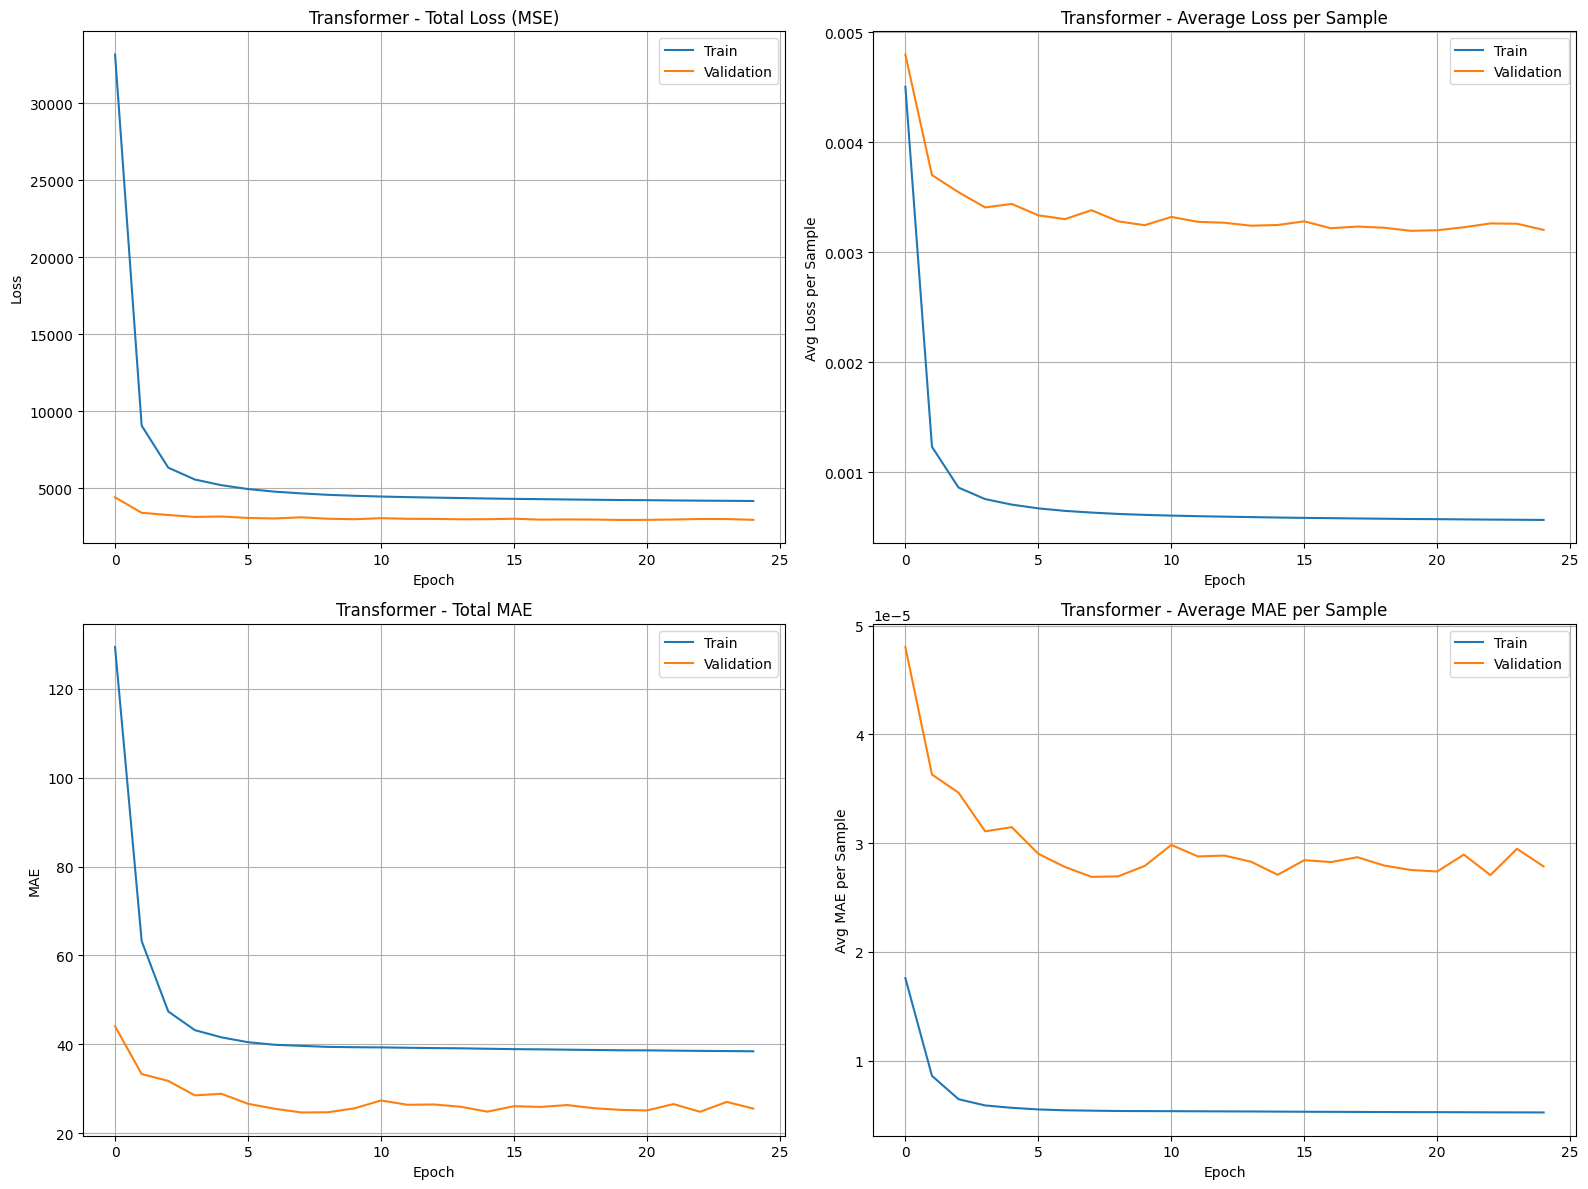


Evaluating Transformer model on test set...



Transformer - Test Evaluation Metrics:
  Overall:  MSE: 2813.59, RMSE: 53.04, MAE: 25.52, R²: 0.9696, WAPE: 11.26%
  Daytime:  MSE: 5640.55, RMSE: 75.10, MAE: 48.55, R²: 0.9315, WAPE: 10.68%
  Nighttime: MSE: 7.51, RMSE: 2.74, MAE: 2.66, R²: -1.8806, WAPE: 843.92%
  Inference Speed: 7388289.22 samples/sec, 0.0001 ms/sample
  Total time: 0.1245 sec for 919800 samples
Model saved to checkpoints/Transformer_best_20250502_173216.pt with metadata.
Best model saved to checkpoints/Transformer_best_20250502_173216.pt
Saved model checkpoint logged to wandb: checkpoints/Transformer_best_20250502_173216.pt


test/inference_speed_samples_per_sec,▁
test/inference_time_ms_per_sample,▁
test/mae,▁
test/mse,▁
test/r2,▁
test/rmse,▁
test/wape,▁
train/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


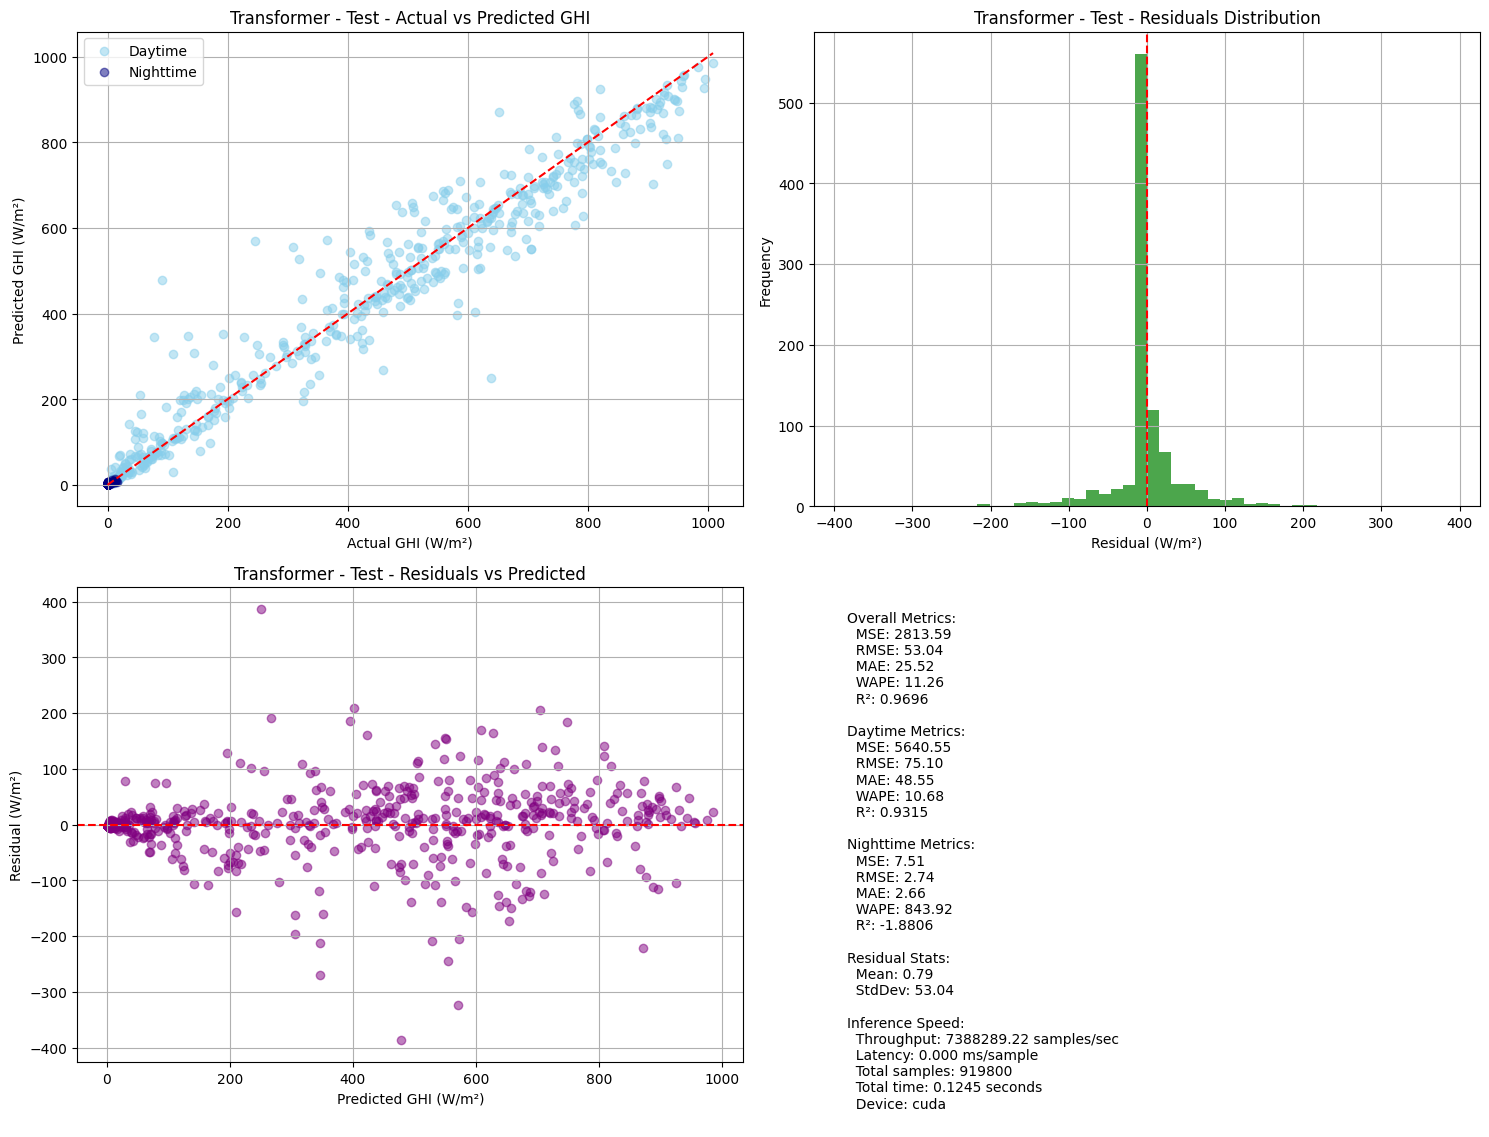

In [10]:
model_name = "Transformer"

# Train the Transformer model
transformer_history, transformer_val_metrics, transformer_test_metrics = run_experiment_pipeline(
    transformer_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)

### 3.3 Informer Model

The Informer model is a recent advancement in time series forecasting that addresses the limitations of standard Transformer models for long sequence prediction. Key innovations include:

- **ProbSparse Self-attention**: Reduces complexity from O(L²) to O(L log L) where L is sequence length.
- **Self-attention Distilling**: Progressive downsampling of hidden states along the encoder.
- **Generative Decoder**: Enables long sequence prediction with minimal compute.

For solar radiation forecasting, Informer can efficiently capture daily, weekly, and seasonal patterns while focusing computational resources on the most informative timestamps.

In [11]:
from models.informer import InformerModel

# Create Informer model
informer_model = InformerModel(
    input_dim=temporal_dim,           # Dimension of input features
    static_dim=static_dim,            # Dimension of static features
    d_model=128,                      # Model dimension
    n_heads=4,                        # Number of attention heads
    e_layers=2,                       # Number of encoder layers
    d_ff=256,                         # Dimension of feedforward network
    dropout=0.2,                      # Dropout rate
    activation='gelu'                 # Activation function
).to(device)

# Print the model
print_model_info(informer_model, temporal_features.shape, static_features.shape)

Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Model: InformerModel
Total parameters: 280,449
Trainable parameters: 280,449
Non-trainable parameters: 0

Model structure:
InformerModel(
  (enc_embedding): Linear(in_features=19, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=

Training Informer model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Creating new wandb run for Informer


Training config: {'PATIENCE': 5, 'LR': 0.0001, 'DEBUG_MODE': False, 'N_EPOCHS': 30, 'BATCH_SIZE': 8192, 'NUM_WORKERS': 16, 'USE_WANDB': True, 'WANDB_USERNAME': 'tin-hoang', 'WANDB_PROJECT': 'EEEM073-Solar-Radiation', 'LOOKBACK': 24, 'TIME_FEATURES': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos'], 'SELECTED_FEATURES': ['air_temperature', 'wind_speed', 'relative_humidity', 'cloud_type', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'nighttime_mask', 'cld_opd_dcomp', 'aod'], 'STATIC_FEATURES': ['latitude', 'longitude', 'elevation'], 'TARGET_VARIABLE': 'ghi', 'TRAIN_PREPROCESSED_DATA_PATH': 'data/processed/train_normalized_20250430_145157.h5', 'VAL_PREPROCESSED_DATA_PATH': 'data/processed/val_normalized_20250430_145205.h5', 'TEST_PREPROCESSED_DATA_PATH': 'data/processed/test_normalized_20250430_145205.h5', 'SCALER_PATH': 'data/processed/scalers_20250430_145206.pkl', 'TEMPORAL_FEATURES_SHAPE': [8192, 24, 1


Validation Informer (Epoch 1) Evaluation Metrics:
  Overall:  MSE: 3916.05, RMSE: 62.58, MAE: 32.60, R²: 0.9573, WAPE: 14.35%
  Daytime:  MSE: 7841.13, RMSE: 88.55, MAE: 62.75, R²: 0.9018, WAPE: 13.77%
  Nighttime: MSE: 19.63, RMSE: 4.43, MAE: 2.67, R²: -6.3447, WAPE: 822.18%
  Inference Speed: 9640551.20 samples/sec, 0.0001 ms/sample
  Total time: 0.0951 sec for 917280 samples
Epoch 1/30 | Train Loss: 14131.8877, Train MAE: 73.6179 | Val Loss: 3916.0457, Val MAE: 32.5971 | LR: 0.000100



Validation Informer (Epoch 2) Evaluation Metrics:
  Overall:  MSE: 3434.53, RMSE: 58.60, MAE: 29.04, R²: 0.9625, WAPE: 12.78%
  Daytime:  MSE: 6880.23, RMSE: 82.95, MAE: 55.66, R²: 0.9139, WAPE: 12.21%
  Nighttime: MSE: 14.01, RMSE: 3.74, MAE: 2.61, R²: -4.2408, WAPE: 806.29%
  Inference Speed: 8747638.04 samples/sec, 0.0001 ms/sample
  Total time: 0.1049 sec for 917280 samples
Epoch 2/30 | Train Loss: 5989.1646, Train MAE: 44.8134 | Val Loss: 3434.5349, Val MAE: 29.0405 | LR: 0.000100



Validation Informer (Epoch 3) Evaluation Metrics:
  Overall:  MSE: 3319.73, RMSE: 57.62, MAE: 28.59, R²: 0.9638, WAPE: 12.59%
  Daytime:  MSE: 6653.62, RMSE: 81.57, MAE: 54.91, R²: 0.9167, WAPE: 12.05%
  Nighttime: MSE: 10.20, RMSE: 3.19, MAE: 2.47, R²: -2.8154, WAPE: 762.75%
  Inference Speed: 8143386.66 samples/sec, 0.0001 ms/sample
  Total time: 0.1126 sec for 917280 samples
Epoch 3/30 | Train Loss: 5248.4995, Train MAE: 40.4013 | Val Loss: 3319.7302, Val MAE: 28.5943 | LR: 0.000100



Validation Informer (Epoch 4) Evaluation Metrics:
  Overall:  MSE: 3224.38, RMSE: 56.78, MAE: 28.10, R²: 0.9648, WAPE: 12.37%
  Daytime:  MSE: 6449.58, RMSE: 80.31, MAE: 53.06, R²: 0.9192, WAPE: 11.64%
  Nighttime: MSE: 22.72, RMSE: 4.77, MAE: 3.32, R²: -7.5021, WAPE: 1023.90%
  Inference Speed: 8938348.39 samples/sec, 0.0001 ms/sample
  Total time: 0.1026 sec for 917280 samples
Epoch 4/30 | Train Loss: 4858.8052, Train MAE: 37.9657 | Val Loss: 3224.3765, Val MAE: 28.0980 | LR: 0.000100



Validation Informer (Epoch 5) Evaluation Metrics:
  Overall:  MSE: 3211.11, RMSE: 56.67, MAE: 28.30, R²: 0.9650, WAPE: 12.46%
  Daytime:  MSE: 6433.76, RMSE: 80.21, MAE: 54.55, R²: 0.9194, WAPE: 11.97%
  Nighttime: MSE: 11.99, RMSE: 3.46, MAE: 2.25, R²: -3.4874, WAPE: 692.50%
  Inference Speed: 9746717.84 samples/sec, 0.0001 ms/sample
  Total time: 0.0941 sec for 917280 samples
Epoch 5/30 | Train Loss: 4626.7871, Train MAE: 37.1429 | Val Loss: 3211.1060, Val MAE: 28.3024 | LR: 0.000100



Validation Informer (Epoch 6) Evaluation Metrics:
  Overall:  MSE: 3143.44, RMSE: 56.07, MAE: 27.52, R²: 0.9657, WAPE: 12.11%
  Daytime:  MSE: 6297.34, RMSE: 79.36, MAE: 52.44, R²: 0.9212, WAPE: 11.51%
  Nighttime: MSE: 12.58, RMSE: 3.55, MAE: 2.78, R²: -3.7057, WAPE: 856.67%
  Inference Speed: 8878427.58 samples/sec, 0.0001 ms/sample
  Total time: 0.1033 sec for 917280 samples
Epoch 6/30 | Train Loss: 4485.4985, Train MAE: 37.1219 | Val Loss: 3143.4446, Val MAE: 27.5156 | LR: 0.000100



Validation Informer (Epoch 7) Evaluation Metrics:
  Overall:  MSE: 3126.37, RMSE: 55.91, MAE: 27.62, R²: 0.9659, WAPE: 12.16%
  Daytime:  MSE: 6268.08, RMSE: 79.17, MAE: 53.69, R²: 0.9215, WAPE: 11.78%
  Nighttime: MSE: 7.61, RMSE: 2.76, MAE: 1.75, R²: -1.8479, WAPE: 539.53%
  Inference Speed: 8849713.91 samples/sec, 0.0001 ms/sample
  Total time: 0.1037 sec for 917280 samples
Epoch 7/30 | Train Loss: 4373.1055, Train MAE: 37.0889 | Val Loss: 3126.3716, Val MAE: 27.6246 | LR: 0.000100



Validation Informer (Epoch 8) Evaluation Metrics:
  Overall:  MSE: 3029.09, RMSE: 55.04, MAE: 26.67, R²: 0.9669, WAPE: 11.74%
  Daytime:  MSE: 6066.05, RMSE: 77.88, MAE: 50.31, R²: 0.9240, WAPE: 11.04%
  Nighttime: MSE: 14.31, RMSE: 3.78, MAE: 3.19, R²: -4.3555, WAPE: 985.33%
  Inference Speed: 8013511.90 samples/sec, 0.0001 ms/sample
  Total time: 0.1145 sec for 917280 samples
Epoch 8/30 | Train Loss: 4256.4668, Train MAE: 36.7686 | Val Loss: 3029.0933, Val MAE: 26.6664 | LR: 0.000100



Validation Informer (Epoch 9) Evaluation Metrics:
  Overall:  MSE: 3086.71, RMSE: 55.56, MAE: 27.31, R²: 0.9663, WAPE: 12.02%
  Daytime:  MSE: 6193.18, RMSE: 78.70, MAE: 53.72, R²: 0.9225, WAPE: 11.79%
  Nighttime: MSE: 2.92, RMSE: 1.71, MAE: 1.08, R²: -0.0940, WAPE: 334.53%
  Inference Speed: 8657230.55 samples/sec, 0.0001 ms/sample
  Total time: 0.1060 sec for 917280 samples
Epoch 9/30 | Train Loss: 4170.5122, Train MAE: 36.5070 | Val Loss: 3086.7053, Val MAE: 27.3068 | LR: 0.000100



Validation Informer (Epoch 10) Evaluation Metrics:
  Overall:  MSE: 2993.55, RMSE: 54.71, MAE: 24.81, R²: 0.9673, WAPE: 10.92%
  Daytime:  MSE: 6008.30, RMSE: 77.51, MAE: 49.26, R²: 0.9248, WAPE: 10.81%
  Nighttime: MSE: 0.82, RMSE: 0.90, MAE: 0.54, R²: 0.6939, WAPE: 165.05%
  Inference Speed: 9842390.75 samples/sec, 0.0001 ms/sample
  Total time: 0.0932 sec for 917280 samples
Epoch 10/30 | Train Loss: 4074.9375, Train MAE: 36.1743 | Val Loss: 2993.5483, Val MAE: 24.8093 | LR: 0.000100



Validation Informer (Epoch 11) Evaluation Metrics:
  Overall:  MSE: 3029.62, RMSE: 55.04, MAE: 26.28, R²: 0.9669, WAPE: 11.57%
  Daytime:  MSE: 6079.38, RMSE: 77.97, MAE: 51.43, R²: 0.9239, WAPE: 11.28%
  Nighttime: MSE: 2.14, RMSE: 1.46, MAE: 1.32, R²: 0.2002, WAPE: 406.64%
  Inference Speed: 9909315.43 samples/sec, 0.0001 ms/sample
  Total time: 0.0926 sec for 917280 samples
Epoch 11/30 | Train Loss: 4028.3550, Train MAE: 36.3081 | Val Loss: 3029.6208, Val MAE: 26.2806 | LR: 0.000100



Validation Informer (Epoch 12) Evaluation Metrics:
  Overall:  MSE: 2994.02, RMSE: 54.72, MAE: 25.86, R²: 0.9673, WAPE: 11.38%
  Daytime:  MSE: 6008.01, RMSE: 77.51, MAE: 50.66, R²: 0.9248, WAPE: 11.12%
  Nighttime: MSE: 2.05, RMSE: 1.43, MAE: 1.24, R²: 0.2347, WAPE: 381.59%
  Inference Speed: 8248118.08 samples/sec, 0.0001 ms/sample
  Total time: 0.1112 sec for 917280 samples
Epoch 12/30 | Train Loss: 3984.9312, Train MAE: 36.3376 | Val Loss: 2994.0242, Val MAE: 25.8559 | LR: 0.000100



Validation Informer (Epoch 13) Evaluation Metrics:
  Overall:  MSE: 2981.90, RMSE: 54.61, MAE: 25.61, R²: 0.9675, WAPE: 11.27%
  Daytime:  MSE: 5982.17, RMSE: 77.34, MAE: 49.61, R²: 0.9251, WAPE: 10.89%
  Nighttime: MSE: 3.54, RMSE: 1.88, MAE: 1.78, R²: -0.3230, WAPE: 549.68%
  Inference Speed: 9124253.96 samples/sec, 0.0001 ms/sample
  Total time: 0.1005 sec for 917280 samples
Epoch 13/30 | Train Loss: 3942.6492, Train MAE: 36.3473 | Val Loss: 2981.8970, Val MAE: 25.6093 | LR: 0.000100



Validation Informer (Epoch 14) Evaluation Metrics:
  Overall:  MSE: 2962.30, RMSE: 54.43, MAE: 25.49, R²: 0.9677, WAPE: 11.22%
  Daytime:  MSE: 5939.64, RMSE: 77.07, MAE: 48.63, R²: 0.9256, WAPE: 10.67%
  Nighttime: MSE: 6.71, RMSE: 2.59, MAE: 2.52, R²: -1.5111, WAPE: 777.56%
  Inference Speed: 9229825.36 samples/sec, 0.0001 ms/sample
  Total time: 0.0994 sec for 917280 samples
Epoch 14/30 | Train Loss: 3913.3167, Train MAE: 36.2343 | Val Loss: 2962.3015, Val MAE: 25.4910 | LR: 0.000100



Validation Informer (Epoch 15) Evaluation Metrics:
  Overall:  MSE: 2964.06, RMSE: 54.44, MAE: 25.50, R²: 0.9677, WAPE: 11.22%
  Daytime:  MSE: 5948.69, RMSE: 77.13, MAE: 50.25, R²: 0.9255, WAPE: 11.03%
  Nighttime: MSE: 1.24, RMSE: 1.11, MAE: 0.93, R²: 0.5357, WAPE: 286.77%
  Inference Speed: 8479029.54 samples/sec, 0.0001 ms/sample
  Total time: 0.1082 sec for 917280 samples
Epoch 15/30 | Train Loss: 3895.0122, Train MAE: 36.2164 | Val Loss: 2964.0642, Val MAE: 25.4973 | LR: 0.000100



Validation Informer (Epoch 16) Evaluation Metrics:
  Overall:  MSE: 2970.31, RMSE: 54.50, MAE: 24.22, R²: 0.9676, WAPE: 10.66%
  Daytime:  MSE: 5961.82, RMSE: 77.21, MAE: 48.19, R²: 0.9254, WAPE: 10.57%
  Nighttime: MSE: 0.66, RMSE: 0.81, MAE: 0.41, R²: 0.7547, WAPE: 127.42%
  Inference Speed: 8612733.62 samples/sec, 0.0001 ms/sample
  Total time: 0.1065 sec for 917280 samples
Epoch 16/30 | Train Loss: 3874.4883, Train MAE: 36.2032 | Val Loss: 2970.3130, Val MAE: 24.2156 | LR: 0.000100



Validation Informer (Epoch 17) Evaluation Metrics:
  Overall:  MSE: 2968.22, RMSE: 54.48, MAE: 25.43, R²: 0.9676, WAPE: 11.19%
  Daytime:  MSE: 5957.14, RMSE: 77.18, MAE: 50.15, R²: 0.9254, WAPE: 11.00%
  Nighttime: MSE: 1.13, RMSE: 1.06, MAE: 0.88, R²: 0.5757, WAPE: 271.81%
  Inference Speed: 8398973.03 samples/sec, 0.0001 ms/sample
  Total time: 0.1092 sec for 917280 samples
Epoch 17/30 | Train Loss: 3859.4734, Train MAE: 36.1955 | Val Loss: 2968.2209, Val MAE: 25.4274 | LR: 0.000100



Validation Informer (Epoch 18) Evaluation Metrics:
  Overall:  MSE: 2952.70, RMSE: 54.34, MAE: 24.36, R²: 0.9678, WAPE: 10.72%
  Daytime:  MSE: 5926.32, RMSE: 76.98, MAE: 48.38, R²: 0.9258, WAPE: 10.62%
  Nighttime: MSE: 0.80, RMSE: 0.90, MAE: 0.52, R²: 0.6991, WAPE: 161.56%
  Inference Speed: 9291974.11 samples/sec, 0.0001 ms/sample
  Total time: 0.0987 sec for 917280 samples
Epoch 18/30 | Train Loss: 3837.6321, Train MAE: 36.0541 | Val Loss: 2952.7031, Val MAE: 24.3631 | LR: 0.000100



Validation Informer (Epoch 19) Evaluation Metrics:
  Overall:  MSE: 2952.81, RMSE: 54.34, MAE: 24.32, R²: 0.9678, WAPE: 10.70%
  Daytime:  MSE: 5926.55, RMSE: 76.98, MAE: 48.39, R²: 0.9258, WAPE: 10.62%
  Nighttime: MSE: 0.78, RMSE: 0.89, MAE: 0.43, R²: 0.7067, WAPE: 133.43%
  Inference Speed: 7949828.23 samples/sec, 0.0001 ms/sample
  Total time: 0.1154 sec for 917280 samples
Epoch 19/30 | Train Loss: 3812.4875, Train MAE: 35.9278 | Val Loss: 2952.8086, Val MAE: 24.3212 | LR: 0.000100



Validation Informer (Epoch 20) Evaluation Metrics:
  Overall:  MSE: 2962.96, RMSE: 54.43, MAE: 25.82, R²: 0.9677, WAPE: 11.36%
  Daytime:  MSE: 5944.99, RMSE: 77.10, MAE: 50.25, R²: 0.9256, WAPE: 11.03%
  Nighttime: MSE: 2.70, RMSE: 1.64, MAE: 1.56, R²: -0.0117, WAPE: 481.57%
  Inference Speed: 8963128.43 samples/sec, 0.0001 ms/sample
  Total time: 0.1023 sec for 917280 samples
Epoch 20/30 | Train Loss: 3795.6504, Train MAE: 35.8927 | Val Loss: 2962.9561, Val MAE: 25.8156 | LR: 0.000100



Validation Informer (Epoch 21) Evaluation Metrics:
  Overall:  MSE: 2947.92, RMSE: 54.29, MAE: 25.01, R²: 0.9678, WAPE: 11.01%
  Daytime:  MSE: 5913.20, RMSE: 76.90, MAE: 48.17, R²: 0.9260, WAPE: 10.57%
  Nighttime: MSE: 4.30, RMSE: 2.07, MAE: 2.02, R²: -0.6070, WAPE: 621.49%
  Inference Speed: 9746964.77 samples/sec, 0.0001 ms/sample
  Total time: 0.0941 sec for 917280 samples
Epoch 21/30 | Train Loss: 3762.3521, Train MAE: 35.7559 | Val Loss: 2947.9197, Val MAE: 25.0076 | LR: 0.000100



Validation Informer (Epoch 22) Evaluation Metrics:
  Overall:  MSE: 2931.43, RMSE: 54.14, MAE: 24.19, R²: 0.9680, WAPE: 10.65%
  Daytime:  MSE: 5883.77, RMSE: 76.71, MAE: 48.22, R²: 0.9263, WAPE: 10.58%
  Nighttime: MSE: 0.65, RMSE: 0.80, MAE: 0.34, R²: 0.7580, WAPE: 104.12%
  Inference Speed: 9575408.29 samples/sec, 0.0001 ms/sample
  Total time: 0.0958 sec for 917280 samples
Epoch 22/30 | Train Loss: 3729.1099, Train MAE: 35.6092 | Val Loss: 2931.4280, Val MAE: 24.1892 | LR: 0.000100



Validation Informer (Epoch 23) Evaluation Metrics:
  Overall:  MSE: 2987.61, RMSE: 54.66, MAE: 24.68, R²: 0.9674, WAPE: 10.86%
  Daytime:  MSE: 5993.87, RMSE: 77.42, MAE: 47.78, R²: 0.9250, WAPE: 10.48%
  Nighttime: MSE: 3.30, RMSE: 1.82, MAE: 1.74, R²: -0.2357, WAPE: 536.50%
  Inference Speed: 9574288.34 samples/sec, 0.0001 ms/sample
  Total time: 0.0958 sec for 917280 samples
Epoch 23/30 | Train Loss: 3715.5779, Train MAE: 35.5215 | Val Loss: 2987.6084, Val MAE: 24.6759 | LR: 0.000100



Validation Informer (Epoch 24) Evaluation Metrics:
  Overall:  MSE: 2956.27, RMSE: 54.37, MAE: 24.83, R²: 0.9677, WAPE: 10.93%
  Daytime:  MSE: 5933.00, RMSE: 77.03, MAE: 49.11, R²: 0.9257, WAPE: 10.78%
  Nighttime: MSE: 1.27, RMSE: 1.13, MAE: 0.74, R²: 0.5236, WAPE: 228.04%
  Inference Speed: 8788100.20 samples/sec, 0.0001 ms/sample
  Total time: 0.1044 sec for 917280 samples
Epoch 24/30 | Train Loss: 3693.3606, Train MAE: 35.3888 | Val Loss: 2956.2664, Val MAE: 24.8342 | LR: 0.000100



Validation Informer (Epoch 25) Evaluation Metrics:
  Overall:  MSE: 2952.68, RMSE: 54.34, MAE: 24.79, R²: 0.9678, WAPE: 10.91%
  Daytime:  MSE: 5926.15, RMSE: 76.98, MAE: 49.06, R²: 0.9258, WAPE: 10.77%
  Nighttime: MSE: 0.93, RMSE: 0.96, MAE: 0.69, R²: 0.6519, WAPE: 213.00%
  Inference Speed: 8517001.84 samples/sec, 0.0001 ms/sample
  Total time: 0.1077 sec for 917280 samples
Epoch 25/30 | Train Loss: 3684.7056, Train MAE: 35.3176 | Val Loss: 2952.6785, Val MAE: 24.7871 | LR: 0.000100



Validation Informer (Epoch 26) Evaluation Metrics:
  Overall:  MSE: 2944.70, RMSE: 54.27, MAE: 24.60, R²: 0.9679, WAPE: 10.83%
  Daytime:  MSE: 5910.42, RMSE: 76.88, MAE: 48.94, R²: 0.9260, WAPE: 10.74%
  Nighttime: MSE: 0.64, RMSE: 0.80, MAE: 0.43, R²: 0.7589, WAPE: 131.98%
  Inference Speed: 8516379.69 samples/sec, 0.0001 ms/sample
  Total time: 0.1077 sec for 917280 samples
Epoch 26/30 | Train Loss: 3672.8137, Train MAE: 35.2479 | Val Loss: 2944.7004, Val MAE: 24.5971 | LR: 0.000100



Validation Informer (Epoch 27) Evaluation Metrics:
  Overall:  MSE: 2924.34, RMSE: 54.08, MAE: 24.89, R²: 0.9681, WAPE: 10.96%
  Daytime:  MSE: 5867.57, RMSE: 76.60, MAE: 48.44, R²: 0.9265, WAPE: 10.63%
  Nighttime: MSE: 2.61, RMSE: 1.61, MAE: 1.52, R²: 0.0248, WAPE: 467.56%
  Inference Speed: 9012406.27 samples/sec, 0.0001 ms/sample
  Total time: 0.1018 sec for 917280 samples
Epoch 27/30 | Train Loss: 3662.0210, Train MAE: 35.1859 | Val Loss: 2924.3379, Val MAE: 24.8933 | LR: 0.000100



Validation Informer (Epoch 28) Evaluation Metrics:
  Overall:  MSE: 2945.52, RMSE: 54.27, MAE: 25.20, R²: 0.9679, WAPE: 11.09%
  Daytime:  MSE: 5906.23, RMSE: 76.85, MAE: 48.09, R²: 0.9260, WAPE: 10.55%
  Nighttime: MSE: 6.43, RMSE: 2.54, MAE: 2.48, R²: -1.4063, WAPE: 764.66%
  Inference Speed: 8282191.30 samples/sec, 0.0001 ms/sample
  Total time: 0.1108 sec for 917280 samples
Epoch 28/30 | Train Loss: 3648.6897, Train MAE: 35.0287 | Val Loss: 2945.5173, Val MAE: 25.2020 | LR: 0.000100



Validation Informer (Epoch 29) Evaluation Metrics:
  Overall:  MSE: 2934.99, RMSE: 54.18, MAE: 24.72, R²: 0.9680, WAPE: 10.88%
  Daytime:  MSE: 5890.30, RMSE: 76.75, MAE: 48.71, R²: 0.9262, WAPE: 10.69%
  Nighttime: MSE: 1.27, RMSE: 1.13, MAE: 0.91, R²: 0.5250, WAPE: 281.64%
  Inference Speed: 9185642.32 samples/sec, 0.0001 ms/sample
  Total time: 0.0999 sec for 917280 samples
Epoch 29/30 | Train Loss: 3630.0957, Train MAE: 34.8386 | Val Loss: 2934.9937, Val MAE: 24.7217 | LR: 0.000100



Validation Informer (Epoch 30) Evaluation Metrics:
  Overall:  MSE: 2940.40, RMSE: 54.23, MAE: 24.29, R²: 0.9679, WAPE: 10.69%
  Daytime:  MSE: 5901.32, RMSE: 76.82, MAE: 47.89, R²: 0.9261, WAPE: 10.51%
  Nighttime: MSE: 1.09, RMSE: 1.05, MAE: 0.86, R²: 0.5906, WAPE: 264.83%
  Inference Speed: 8471990.53 samples/sec, 0.0001 ms/sample
  Total time: 0.1083 sec for 917280 samples
Epoch 30/30 | Train Loss: 3627.3953, Train MAE: 34.8902 | Val Loss: 2940.3953, Val MAE: 24.2886 | LR: 0.000100
Loading best model from training session. The model object now can be used to make predictions.
Keeping wandb run open as requested (keep_run_open=True)


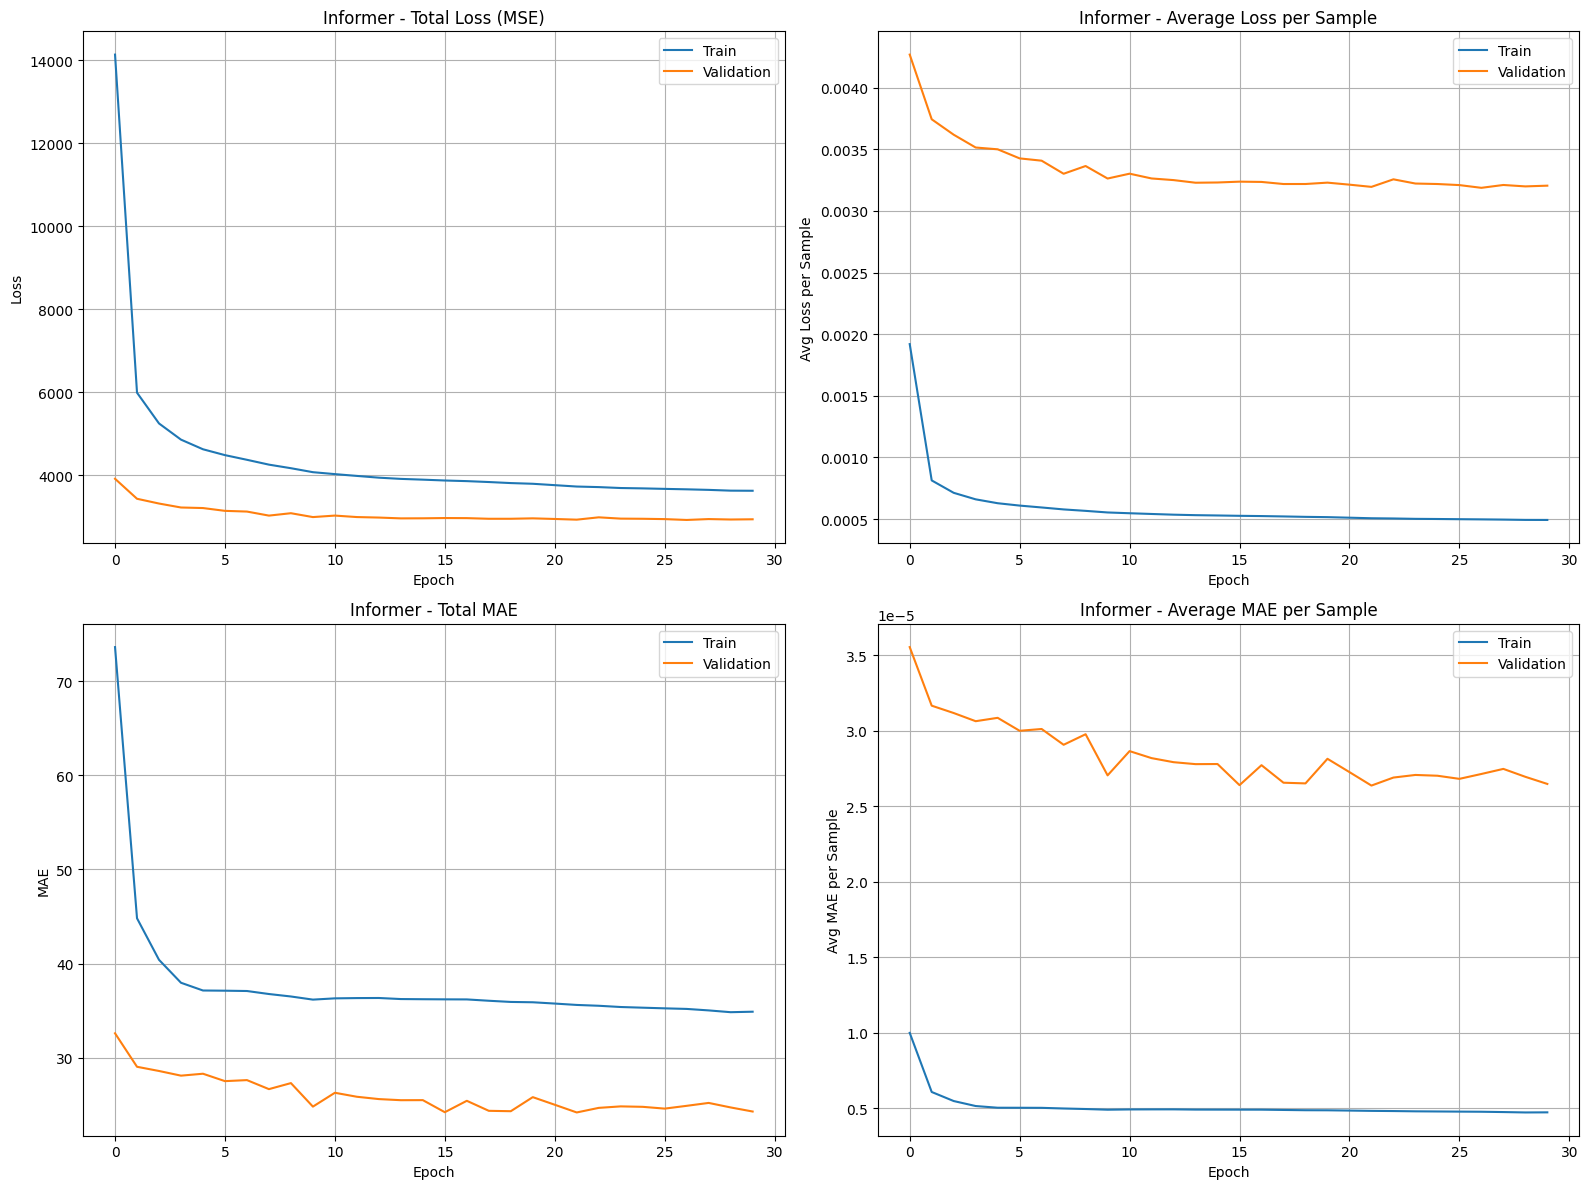


Evaluating Informer model on test set...



Informer - Test Evaluation Metrics:
  Overall:  MSE: 2789.35, RMSE: 52.81, MAE: 24.03, R²: 0.9699, WAPE: 10.61%
  Daytime:  MSE: 5598.40, RMSE: 74.82, MAE: 47.39, R²: 0.9320, WAPE: 10.43%
  Nighttime: MSE: 1.04, RMSE: 1.02, MAE: 0.85, R²: 0.5997, WAPE: 268.56%
  Inference Speed: 8986077.63 samples/sec, 0.0001 ms/sample
  Total time: 0.1024 sec for 919800 samples
Model saved to checkpoints/Informer_best_20250502_190015.pt with metadata.
Best model saved to checkpoints/Informer_best_20250502_190015.pt
Saved model checkpoint logged to wandb: checkpoints/Informer_best_20250502_190015.pt


test/inference_speed_samples_per_sec,▁
test/inference_time_ms_per_sample,▁
test/mae,▁
test/mse,▁
test/r2,▁
test/rmse,▁
test/wape,▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


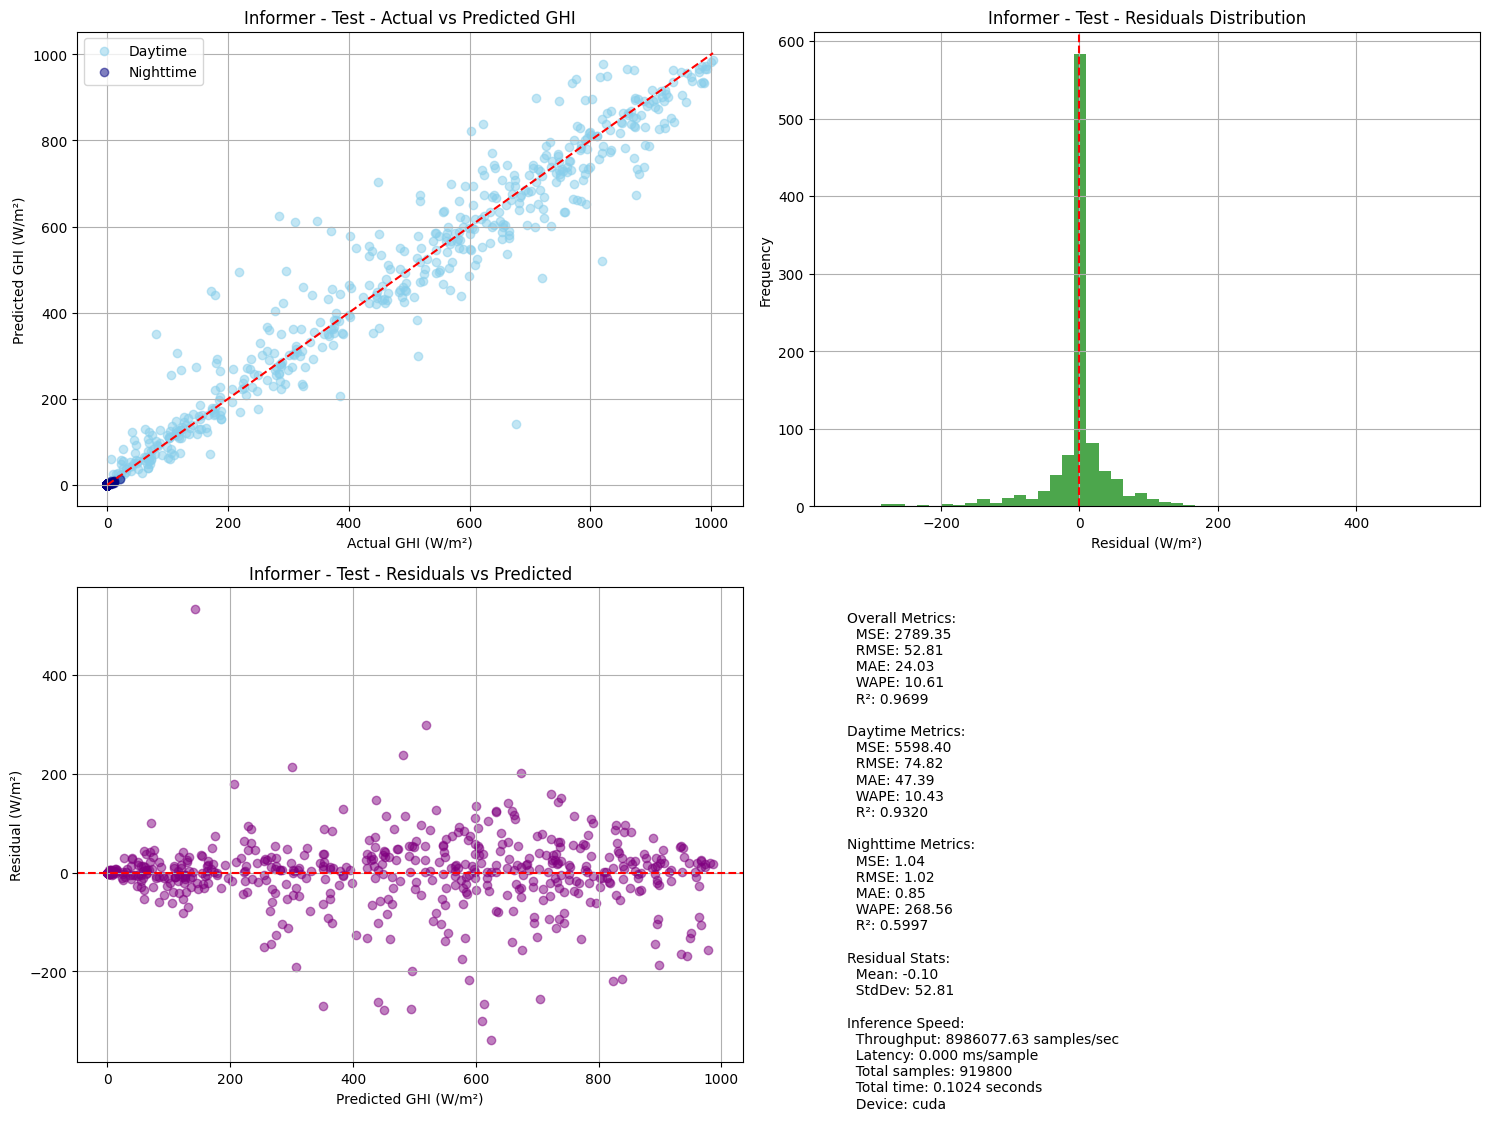

In [12]:
model_name = "Informer"

# Train the Informer model with a lower learning rate
informer_history, informer_val_metrics, informer_test_metrics = run_experiment_pipeline(
    informer_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)

## 4. Model Comparison

After training all models, we compare their performance to determine which advanced architecture works best for GHI forecasting.

## 4.1 Compare Advanced Models' Performance

This section compares the overall performance metrics (MSE, RMSE, MAE, R²) of all trained advanced models
on the test dataset. These metrics help us understand which state-of-the-art model provides the most
accurate predictions across the entire test set.


Model Comparison - Test Set:
                        TCN     Transformer        Informer
MSE             2876.858398     2813.594482      2789.35376
RMSE              53.636353       53.043326       52.814333
MAE               25.676012       25.518047        24.03174
WAPE              11.334337       11.264606       10.608494
R²                  0.96892        0.969604        0.969865
Samples/sec  4178549.261103  7388289.223946  8986077.627515
ms/sample          0.000239        0.000135        0.000111


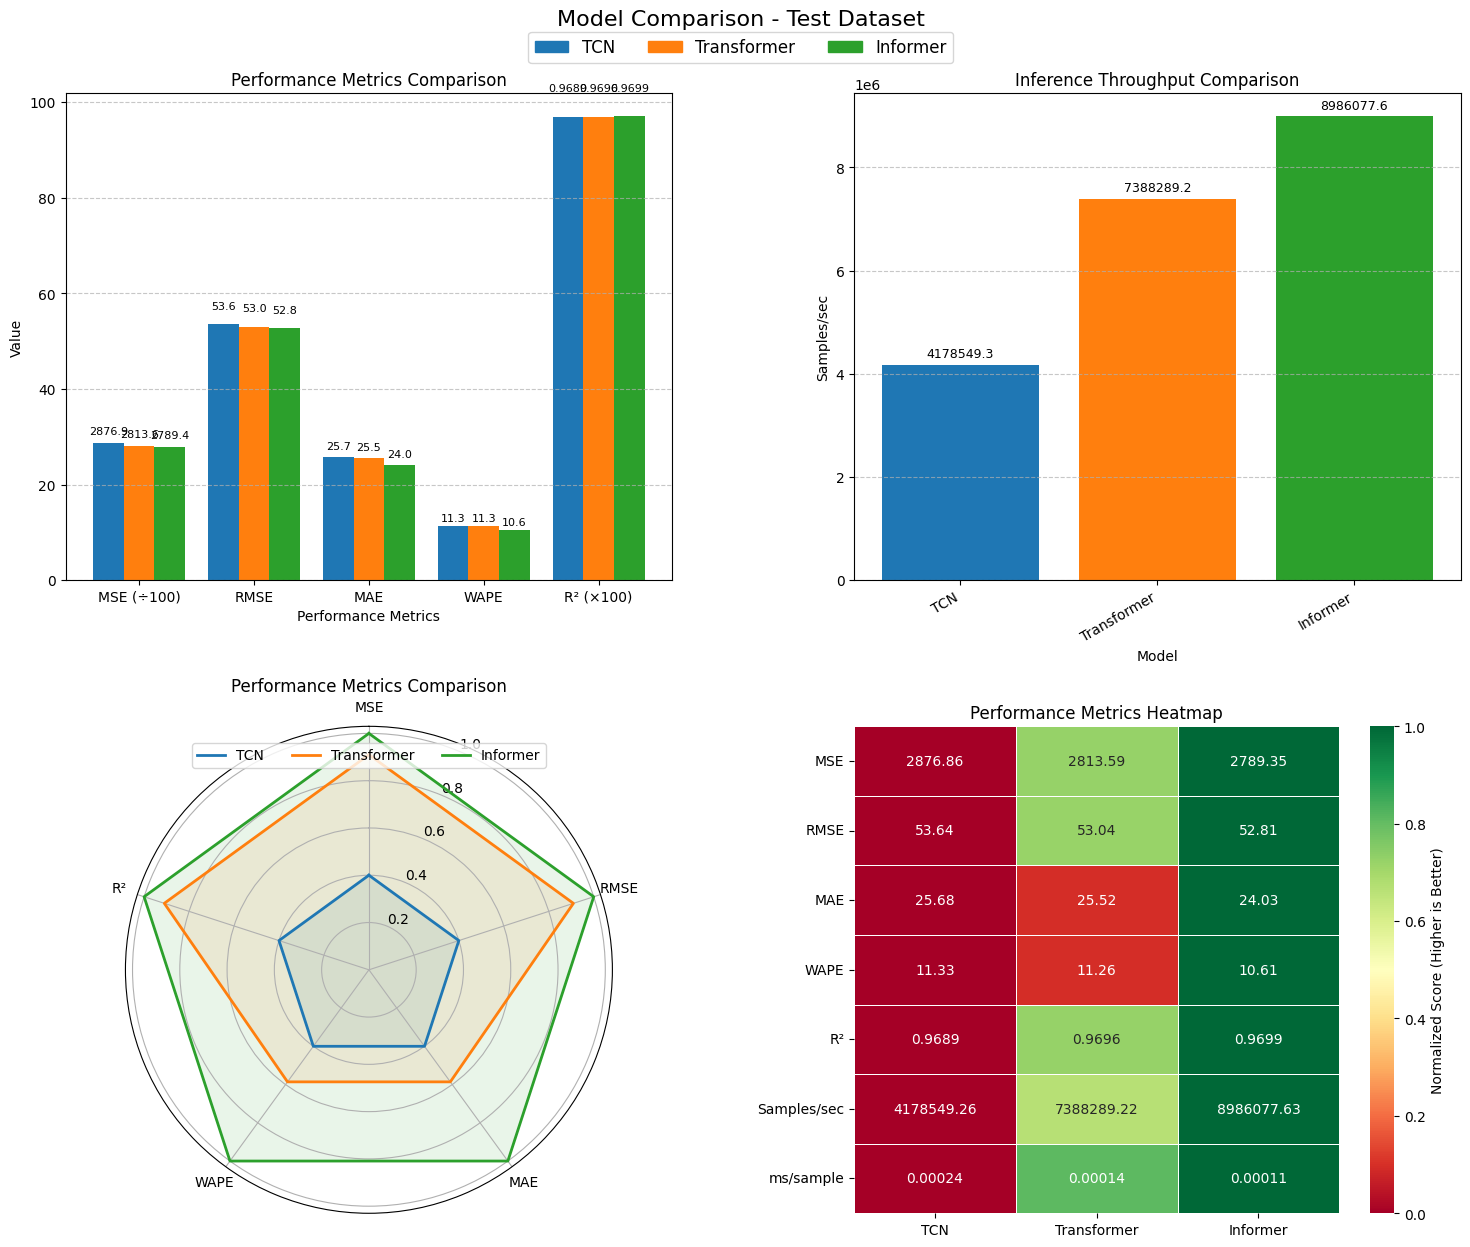

In [13]:
from utils.plot_utils import compare_models

# Create a dictionary of model metrics
model_metrics = {
    'TCN': tcn_test_metrics,
    'Transformer': transformer_test_metrics,
    'Informer': informer_test_metrics
}
# Drop the 'y_pred' and 'y_true' keys from the model metrics
for model in model_metrics:
    model_metrics[model].pop('y_pred', None)
    model_metrics[model].pop('y_true', None)
    model_metrics[model].pop('nighttime_mask', None)

# Save model metrics to a json file for later use
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
json_file_path = f'plots/advanced_model_metrics_{timestamp}.json'
# Fix TypeError: Object of type float32 is not JSON serializable
for model in model_metrics:
    for key, value in model_metrics[model].items():
        if isinstance(value, np.float32):
            model_metrics[model][key] = float(value)
with open(json_file_path, 'w') as f:
    json.dump(model_metrics, f)

# Compare model performance on test set
fig = compare_models(model_metrics, dataset_name='Test')

## 4.2 Model Comparison on Daytime/Nighttime/Overall

Here we analyze model performance separately for daytime and nighttime periods. This is crucial for solar forecasting
as prediction requirements and patterns differ significantly between day and night. The comparison helps identify
which advanced models perform better under different lighting conditions.

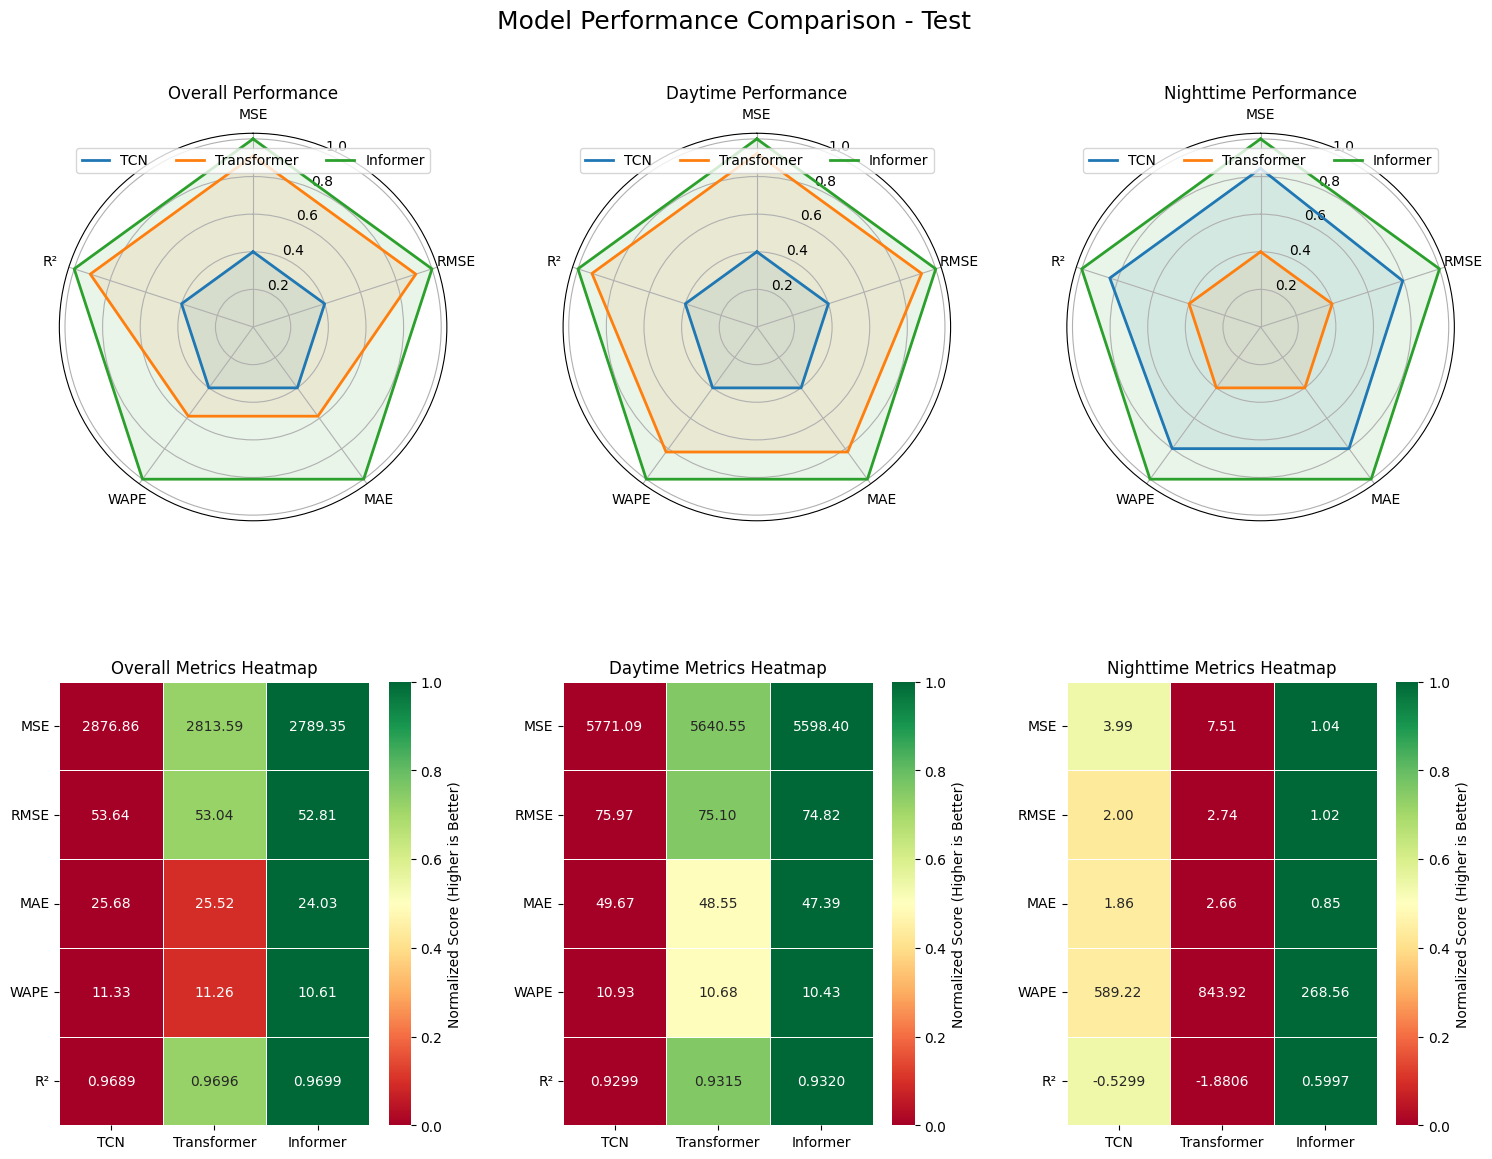

In [14]:
from utils.plot_utils import compare_models_daytime_nighttime

# Generate the comparison plot
comparison_fig = compare_models_daytime_nighttime(model_metrics, dataset_name='Test')

## 5. Visualization and Analysis

This section provides visual analysis of advanced model predictions to better understand model performance.

### 5.1 Time Series Predictions

Visualize predictions over time to compare how each advanced model tracks the actual GHI values. This visualization includes:
- Actual GHI values (ground truth)
- Predictions from each advanced model architecture
- Nighttime periods shaded for context
- Error metrics for the visualized time period

In [15]:
def plot_predictions_over_time(models, model_names, data_loader, target_scaler, num_samples=200, start_idx=0):
    """
    Plot time series predictions for multiple models with nighttime shading if available

    Args:
        models: List of PyTorch models
        model_names: List of model names
        data_loader: Data loader
        target_scaler: Scaler for the target variable
        num_samples: Number of consecutive time steps to plot
        start_idx: Starting index in the dataset
    """
    # Get device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Collect data samples
    all_batches = []
    for batch in data_loader:
        all_batches.append(batch)
        if len(all_batches) * batch['target'].shape[0] > start_idx + num_samples:
            break

    # Combine batches into a single dataset
    all_temporal = []
    all_static = []
    all_targets = []
    all_nighttime = []
    all_time_index_local = []
    has_nighttime = False
    has_time_index_local = False

    for batch in all_batches:
        all_temporal.append(batch['temporal_features'])
        all_static.append(batch['static_features'])
        all_targets.append(batch['target'])
        # Check if nighttime data is available
        if 'nighttime_mask' in batch:
            has_nighttime = True
            all_nighttime.append(batch['nighttime_mask'])
        # Check if time_index_local is available
        if 'time_index_local' in batch:
            has_time_index_local = True
            # Store the time index values as they are
            if isinstance(batch['time_index_local'], list):
                all_time_index_local.extend(batch['time_index_local'])
            else:
                all_time_index_local.append(batch['time_index_local'])

    all_temporal = torch.cat(all_temporal, dim=0)
    all_static = torch.cat(all_static, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    if has_nighttime:
        all_nighttime = torch.cat(all_nighttime, dim=0)

    # Get the subset for visualization
    temporal = all_temporal[start_idx:start_idx+num_samples].to(device)
    static = all_static[start_idx:start_idx+num_samples].to(device)
    targets = all_targets[start_idx:start_idx+num_samples].cpu().numpy()

    if has_nighttime:
        nighttime = all_nighttime[start_idx:start_idx+num_samples].cpu().numpy()
        # Ensure nighttime is a 1D array
        if len(nighttime.shape) > 1:
            nighttime = nighttime.flatten() if nighttime.shape[1] == 1 else nighttime[:,0]

    # Get time index for x-axis if available
    x_values = None
    if has_time_index_local and len(all_time_index_local) >= start_idx + num_samples:
        # Extract the time values for the plotting window
        x_values = all_time_index_local[start_idx:start_idx+num_samples]

        # Try to convert to datetime objects if they are strings
        if isinstance(x_values[0], str):
            try:
                # Try different datetime formats
                date_formats = ['%Y-%m-%d %H:%M:%S', '%Y-%m-%d %H:%M', '%Y-%m-%dT%H:%M:%S', '%Y%m%d%H%M%S']
                for date_format in date_formats:
                    try:
                        x_values = [datetime.strptime(t, date_format) for t in x_values]
                        print(f"Successfully parsed dates with format: {date_format}")
                        break
                    except ValueError:
                        continue

                # If we couldn't parse with any format, notify and use indices
                if isinstance(x_values[0], str):
                    print(f"Could not parse date format: {x_values[0]}, using indices instead")
                    x_values = None

            except (ValueError, TypeError) as e:
                # If conversion fails, fall back to using indices
                print(f"Error converting time_index_local to datetime: {e}, using indices instead")
                x_values = None

    # Generate predictions
    predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            outputs = model(temporal, static).cpu().numpy()
            predictions.append(outputs)

    # Inverse transform to original scale
    y_true_orig = target_scaler.inverse_transform(targets.reshape(-1, 1)).flatten()
    y_pred_orig_list = [target_scaler.inverse_transform(pred.reshape(-1, 1)).flatten() for pred in predictions]

    # Create visualization
    fig = plt.figure(figsize=(15, 8))
    ax = plt.gca()

    # Define colors and line styles for predictions
    colors = ['blue', 'red', 'green', 'magenta', 'cyan', 'orange']
    line_styles = ['--', ':', '-.', '--', ':', '--']

    # Set x-axis values based on availability of time_index_local
    if x_values:
        # Plot actual values with time index
        actual_line, = plt.plot(x_values, y_true_orig, 'k-', label='Actual GHI', linewidth=2)

        # Plot predictions with time index
        pred_lines = []
        handles = [actual_line]
        labels = ['Actual GHI']

        for i, (pred, name) in enumerate(zip(y_pred_orig_list, model_names)):
            color = colors[i % len(colors)]
            style = line_styles[i % len(line_styles)]
            line, = plt.plot(x_values, pred, color=color, linestyle=style, label=f'{name} Predicted', alpha=0.7)
            pred_lines.append(line)
            handles.append(line)
            labels.append(f'{name} Predicted')

        # Format the x-axis to show dates properly
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.xticks(rotation=0)  # Make labels horizontal
        fig.subplots_adjust(bottom=0.15)  # Adjust bottom margin for horizontal labels

        # If we have nighttime data, shade those regions
        if has_nighttime:
            # Modify nighttime shading to work with datetime x-axis
            nighttime_bool = (nighttime > 0.5)
            night_regions = []
            start = None
            for i, is_night in enumerate(nighttime_bool):
                if is_night and start is None:
                    start = i
                elif not is_night and start is not None:
                    night_regions.append((start, i))
                    start = None
            if start is not None:
                night_regions.append((start, len(nighttime_bool)))

            for start, end in night_regions:
                if start < len(x_values) and end <= len(x_values):
                    ax.axvspan(x_values[start], x_values[min(end, len(x_values)-1)],
                              alpha=0.2, color='gray', label='_nolegend_')
    else:
        # Use default integer indices for x-axis
        actual_line, = plt.plot(y_true_orig, 'k-', label='Actual GHI', linewidth=2)

        # Plot predictions and collect handles/labels
        pred_lines = []
        handles = [actual_line]
        labels = ['Actual GHI']

        for i, (pred, name) in enumerate(zip(y_pred_orig_list, model_names)):
            color = colors[i % len(colors)]
            style = line_styles[i % len(line_styles)]
            line, = plt.plot(pred, color=color, linestyle=style, label=f'{name} Predicted', alpha=0.7)
            pred_lines.append(line)
            handles.append(line)
            labels.append(f'{name} Predicted')

        # If we have nighttime data, shade those regions
        if has_nighttime:
            nighttime_bool = (nighttime > 0.5)
            night_regions = []
            start = None
            for i, is_night in enumerate(nighttime_bool):
                if is_night and start is None:
                    start = i
                elif not is_night and start is not None:
                    night_regions.append((start, i))
                    start = None
            if start is not None:
                night_regions.append((start, len(nighttime_bool)))

            for start, end in night_regions:
                ax.axvspan(start, end, alpha=0.2, color='gray', label='_nolegend_')

    # Add nighttime legend if applicable
    if has_nighttime and len(night_regions) > 0:
        night_patch = Patch(facecolor='gray', alpha=0.2, label='Nighttime')
        handles.append(night_patch)
        labels.append('Nighttime')

    # Calculate and display error metrics for the visualization window
    for i, (pred, name) in enumerate(zip(y_pred_orig_list, model_names)):
        rmse = np.sqrt(np.mean((y_true_orig - pred) ** 2))
        mae = np.mean(np.abs(y_true_orig - pred))
        plt.annotate(f"{name}: RMSE={rmse:.2f}, MAE={mae:.2f}",
                     xy=(0.02, 0.97 - 0.03*i),
                     xycoords='axes fraction',
                     fontsize=9,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    plt.title('GHI Predictions Over Time')
    plt.xlabel('Time' if x_values else 'Time Step')
    plt.ylabel('GHI (W/m²)')

    # Set the legend with the correct handles and labels
    plt.legend(handles, labels, loc='upper right')

    plt.grid(True)
    plt.tight_layout()
    # Save the figure
    os.makedirs('plots', exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.savefig(f'plots/predictions_over_time_{timestamp}.png')
    return fig

Successfully parsed dates with format: %Y-%m-%dT%H:%M:%S


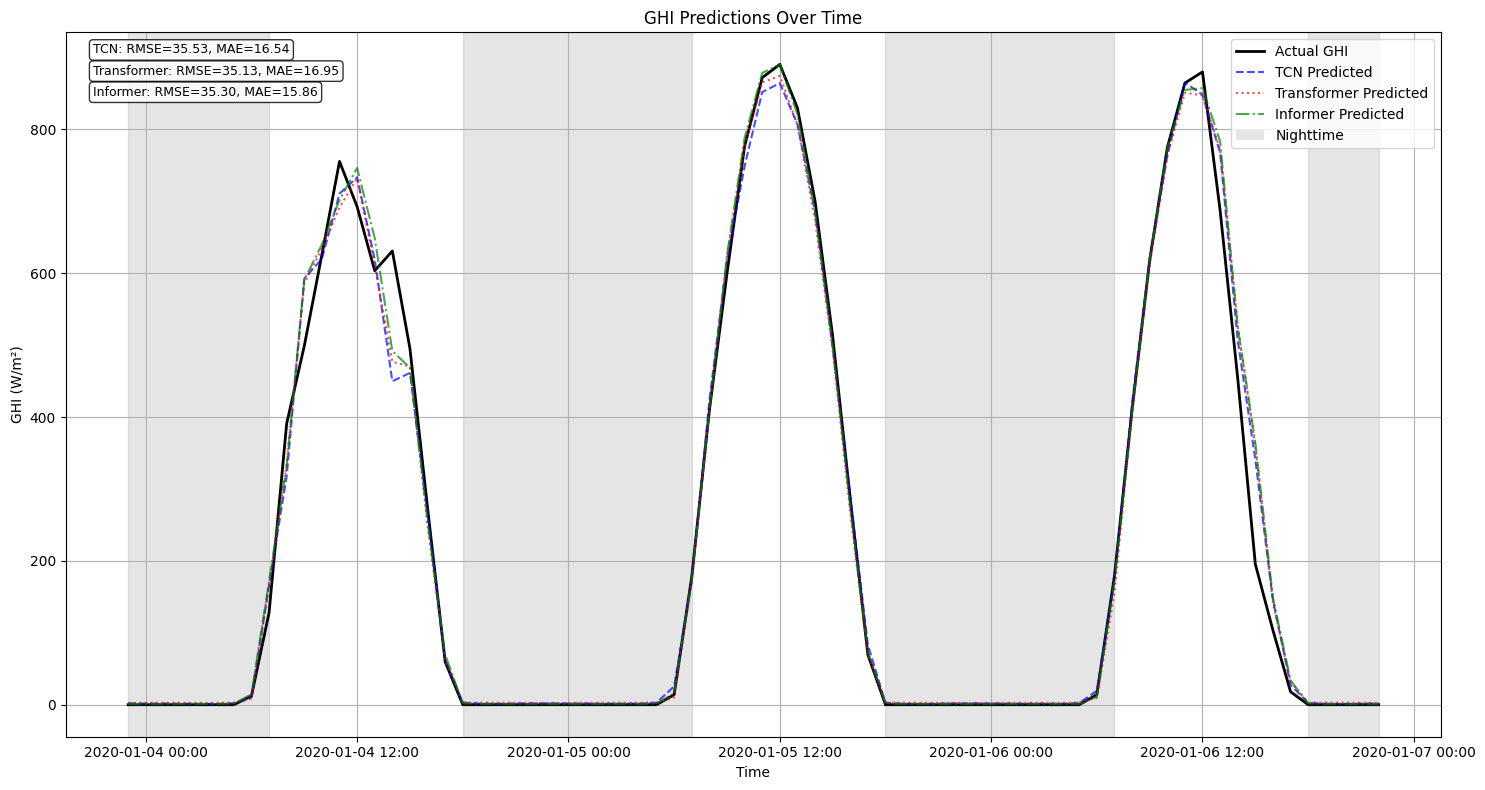

In [16]:
# Plot time series predictions for advanced models
_ = plot_predictions_over_time(
    models=[tcn_model, transformer_model, informer_model],
    model_names=['TCN', 'Transformer', 'Informer'],
    data_loader=test_loader,
    target_scaler=scalers[f'{TARGET_VARIABLE}_scaler'],
    num_samples=72,
    start_idx=40
)